# Интернет-магазин товаров для дома «Пока все ещё тут»

## Введение

### Цель работы:
1. Разработать рекомендации о том, каким клиентам и когда следует рассылать рекламные предложения о каких категориях товаров;
0. Разработать стратегию по увеличению количества продаваемого товара для каждого сегмента;
0. Разработать способы повышения возвращаемости покупателей для различных сегментов.

### Описание данных:
Датасет `ecom_dataset_upd.csv`
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

### Используемые библиотеки и модули:

In [1]:
import pandas as pd

import numpy as np
from scipy import stats
import datetime

import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")
sns.set_theme(rc={'figure.figsize':(12, 6)})

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from pymystem3 import Mystem

## Предобработка данных

### Загрузка данных

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv')
data

date                           customer_id  order_id  \
0     2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1     2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2     2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3     2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4     2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...          ...                                   ...       ...   
7469  2020013021  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
7470  2020013022  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
7471  2020013102  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
7472  2020013112  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
7473  2020013115  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                product  quantity  price  
0       Комнатное растение в горшке Алое Вера, d12, h30         1  142.0  
1     Комнатное растение в горшке Кофе Арабика, d12,...         1  194.0  
2                           Радермахера d-12 см h-20 см         1  112.0  
3                      Хризолидокарпус Лутесценс d-9 см         1  179.0  
4                        Циперус Зумула d-12 см h-25 см         1  112.0  
...                                                 ...       ...    ...  
7469  томата (помидор) Черниченский черри № 116 сорт...         2   38.0  
7470         Дендробиум Санок Анна Грин 1 ствол d-12 см         1  869.0  
7471  Подставка для обуви резиновая Attribute 80x40 ...         1  354.0  
7472  Тагетис крупноцветковый рассада однолетних цве...         1  128.0  
7473  Вешалка для блузок 41 см красный Attribute AHM781         1  104.0  

[7474 rows x 6 columns]

<div style="border: 1px solid; padding: 15px;">
Датасет согласуется с заявленой информацией ранее. Столбцы подписаны корректно. Всего в датасете 7474 событий о покупке товаров. 

Также заметим, что некоторые слова позиции начинаются со строчных букв, а другие с заглавных.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


<div style="border: 1px solid; padding: 15px;">
В данных отсутсвуют пропуски. Изменим тип данных у столбца `date` и рассмотрим такую же возможность у столбца `price`

### Изменение типов данных

In [4]:
# Приведение формата даты и времени
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')
data

date                           customer_id  order_id  \
0    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...                  ...                                   ...       ...   
7469 2020-01-30 21:00:00  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
7470 2020-01-30 22:00:00  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
7471 2020-01-31 02:00:00  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
7472 2020-01-31 12:00:00  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
7473 2020-01-31 15:00:00  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                product  quantity  price  
0       Комнатное растение в горшке Алое Вера, d12, h30         1  142.0  
1     Комнатное растение в горшке Кофе Арабика, d12,...         1  194.0  
2                           Радермахера d-12 см h-20 см         1  112.0  
3                      Хризолидокарпус Лутесценс d-9 см         1  179.0  
4                        Циперус Зумула d-12 см h-25 см         1  112.0  
...                                                 ...       ...    ...  
7469  томата (помидор) Черниченский черри № 116 сорт...         2   38.0  
7470         Дендробиум Санок Анна Грин 1 ствол d-12 см         1  869.0  
7471  Подставка для обуви резиновая Attribute 80x40 ...         1  354.0  
7472  Тагетис крупноцветковый рассада однолетних цве...         1  128.0  
7473  Вешалка для блузок 41 см красный Attribute AHM781         1  104.0  

[7474 rows x 6 columns]

In [5]:
data['price'].astype(int).sum()

3578061

In [6]:
data['price'].sum()

3578084.083333333

<div style="border: 1px solid; padding: 15px;">
Поскольку копейки назначительно влияют на суммарные продажи, то приведем столбец `price` к типу `int`

In [7]:
data['price'] = data['price'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         7474 non-null   datetime64[ns]
 1   customer_id  7474 non-null   object        
 2   order_id     7474 non-null   int64         
 3   product      7474 non-null   object        
 4   quantity     7474 non-null   int64         
 5   price        7474 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 350.5+ KB


<div style="border: 1px solid; padding: 15px;">
Как ранее было сказано, в названиях продуктов есть разница в написании слов, то для поиска дубликатов сделаем все буквы строчными

In [8]:
data['product'] = data['product'].str.lower()
data

date                           customer_id  order_id  \
0    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...                  ...                                   ...       ...   
7469 2020-01-30 21:00:00  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
7470 2020-01-30 22:00:00  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
7471 2020-01-31 02:00:00  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
7472 2020-01-31 12:00:00  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
7473 2020-01-31 15:00:00  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                product  quantity  price  
0       комнатное растение в горшке алое вера, d12, h30         1    142  
1     комнатное растение в горшке кофе арабика, d12,...         1    194  
2                           радермахера d-12 см h-20 см         1    112  
3                      хризолидокарпус лутесценс d-9 см         1    179  
4                        циперус зумула d-12 см h-25 см         1    112  
...                                                 ...       ...    ...  
7469  томата (помидор) черниченский черри № 116 сорт...         2     38  
7470         дендробиум санок анна грин 1 ствол d-12 см         1    869  
7471  подставка для обуви резиновая attribute 80x40 ...         1    354  
7472  тагетис крупноцветковый рассада однолетних цве...         1    128  
7473  вешалка для блузок 41 см красный attribute ahm781         1    104  

[7474 rows x 6 columns]

### Поиск явных и неявных дубликатов

In [9]:
print(f"Количество явных дубликатов: {data.duplicated().sum()}\
        \nДоля явных дубликатов: {data.duplicated().sum()/len(data):.2%}")

Количество явных дубликатов: 0        
Доля явных дубликатов: 0.00%


<div style="border: 1px solid; padding: 15px;">
Явные дубликаты отсутвуют. Проведем поиск неявных

In [10]:
data[['order_id', 'product']].duplicated().sum()

1920

In [11]:
data[data[['order_id', 'product']].duplicated()]

date                           customer_id  order_id  \
58   2018-10-02 18:00:00  b731df05-98fa-4610-8496-716ec530a02c     68474   
59   2018-10-02 19:00:00  b731df05-98fa-4610-8496-716ec530a02c     68474   
60   2018-10-02 20:00:00  b731df05-98fa-4610-8496-716ec530a02c     68474   
63   2018-10-03 04:00:00  b731df05-98fa-4610-8496-716ec530a02c     68474   
94   2018-10-04 13:00:00  32de7df8-8d4f-4c84-a7b9-c41d00dd83ba     68522   
...                  ...                                   ...       ...   
6706 2019-10-28 10:00:00  57cc80a2-2610-4eef-9457-e7c3bf0c72f0     70960   
6711 2019-10-28 21:00:00  cb65d08a-dae7-4890-aef0-bb9f79055e02     73108   
6728 2019-10-31 00:00:00  ffaeab76-3a8d-49ee-860f-17273b2fc8a2     73136   
6729 2019-10-31 02:00:00  ffaeab76-3a8d-49ee-860f-17273b2fc8a2     73136   
6736 2019-10-31 16:00:00  344aa778-e436-419e-a9c6-9b8f37b7c1df     73137   

                                                product  quantity  price  
58    доска гладильная eurogold professional 130х48 ...         1   3299  
59    доска гладильная eurogold professional 130х48 ...         1   3299  
60    доска гладильная eurogold professional 130х48 ...         1   3299  
63    доска гладильная eurogold professional 130х48 ...         1   3299  
94                       эвкалипт гунни d-17 см h-60 см         1   1409  
...                                                 ...       ...    ...  
6706       сумка-тележка 2-х колесная gimi argo красная         1   1087  
6711                                мирт d-9 см h-15 см         1    134  
6728  таз пластмассовый со стиральной доской (иж), 1...         1    397  
6729  таз пластмассовый со стиральной доской (иж), 1...         1    397  
6736         сумка-тележка 2-х колесная gimi argo синяя         1   1087  

[1920 rows x 6 columns]

<div style="border: 1px solid; padding: 15px;">
Всего неявных дубликатов по столбцам `product` и `order_id` 1920. Рассмотрим дубликаты

In [12]:
orders = data[data[['order_id', 'product']].duplicated()]['order_id'].unique()

In [13]:
data.query("order_id == @orders[0]")

date                           customer_id  order_id  \
19 2018-10-01 21:00:00  b731df05-98fa-4610-8496-716ec530a02c     68474   
58 2018-10-02 18:00:00  b731df05-98fa-4610-8496-716ec530a02c     68474   
59 2018-10-02 19:00:00  b731df05-98fa-4610-8496-716ec530a02c     68474   
60 2018-10-02 20:00:00  b731df05-98fa-4610-8496-716ec530a02c     68474   
63 2018-10-03 04:00:00  b731df05-98fa-4610-8496-716ec530a02c     68474   

                                              product  quantity  price  
19  доска гладильная eurogold professional 130х48 ...         1   3299  
58  доска гладильная eurogold professional 130х48 ...         1   3299  
59  доска гладильная eurogold professional 130х48 ...         1   3299  
60  доска гладильная eurogold professional 130х48 ...         1   3299  
63  доска гладильная eurogold professional 130х48 ...         1   3299

In [14]:
data.query("order_id == @orders[1]")

date                           customer_id  order_id  \
80 2018-10-04 09:00:00  32de7df8-8d4f-4c84-a7b9-c41d00dd83ba     68522   
94 2018-10-04 13:00:00  32de7df8-8d4f-4c84-a7b9-c41d00dd83ba     68522   

                           product  quantity  price  
80  эвкалипт гунни d-17 см h-60 см         1   1409  
94  эвкалипт гунни d-17 см h-60 см         1   1409

In [15]:
data.query("order_id == @orders[2]")

date                           customer_id  order_id  \
124 2018-10-07 16:00:00  ce0e0c29-8c8b-4714-84bd-80957224d4cf     68557   
126 2018-10-07 17:00:00  ce0e0c29-8c8b-4714-84bd-80957224d4cf     68557   

                                           product  quantity  price  
124  сумка-тележка хозяйственная gimi market синяя         1   1874  
126  сумка-тележка хозяйственная gimi market синяя         1   1874

In [16]:
data[['customer_id', 'order_id', 'product']].duplicated().sum()

1886

In [17]:
data.groupby('order_id', as_index=False)['customer_id'].nunique().sort_values('customer_id', ascending=False)

order_id  customer_id
2610     72845            4
1914     71480            3
902      69485            3
862      69410            2
1799     71226            2
...        ...          ...
1180     70080            1
1181     70082            1
1182     70087            1
1183     70088            1
3520    112789            1

[3521 rows x 2 columns]

<div style="border: 1px solid; padding: 15px;">
Существуют также заказы с одним и тем же id и товаром, но с разными покупателями.

In [18]:
print(f"Количество продублированных пользователей: {data[data[['order_id', 'product']].duplicated()]['customer_id'].nunique()}")

Количество продублированных пользователей: 285


In [19]:
print(f'Количество продублированных заказов: {len(orders)}')

Количество продублированных заказов: 278


<div style="border: 1px solid; padding: 15px;">
Удалим все найденные строки

In [20]:
data = data[~data[['order_id', 'product']].duplicated()].reset_index(drop=True)
data

date                           customer_id  order_id  \
0    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...                  ...                                   ...       ...   
5549 2020-01-30 21:00:00  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
5550 2020-01-30 22:00:00  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
5551 2020-01-31 02:00:00  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
5552 2020-01-31 12:00:00  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
5553 2020-01-31 15:00:00  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                product  quantity  price  
0       комнатное растение в горшке алое вера, d12, h30         1    142  
1     комнатное растение в горшке кофе арабика, d12,...         1    194  
2                           радермахера d-12 см h-20 см         1    112  
3                      хризолидокарпус лутесценс d-9 см         1    179  
4                        циперус зумула d-12 см h-25 см         1    112  
...                                                 ...       ...    ...  
5549  томата (помидор) черниченский черри № 116 сорт...         2     38  
5550         дендробиум санок анна грин 1 ствол d-12 см         1    869  
5551  подставка для обуви резиновая attribute 80x40 ...         1    354  
5552  тагетис крупноцветковый рассада однолетних цве...         1    128  
5553  вешалка для блузок 41 см красный attribute ahm781         1    104  

[5554 rows x 6 columns]

In [21]:
print(f"Количество пользователей: {data['customer_id'].nunique()}\
        \nКоличество заказов: {data['order_id'].nunique()}\
        \nКоличество позиций товара: {data['product'].nunique()}\
        \nКоличество проданного товара: {data['quantity'].sum()}\
        \nДоход с продаж: {data['price'].sum()} у.е.")

Количество пользователей: 2431        
Количество заказов: 3521        
Количество позиций товара: 2341        
Количество проданного товара: 14353        
Доход с продаж: 2952521 у.е.


<div style="border: 1px solid; padding: 15px;">
    
После удаления части данных осталось **5554 событий**, в которых содержится информация о **3521 заказе** от **2431 пользователя**. Всего было продано **14353 товара** на сумму **2952521 у.е.**.

### Добавление новых столбцов

<div style="border: 1px solid; padding: 15px;">
    
Добавим столбец `value` c суммой события и столбец `total` с суммой заказа

In [22]:
data['value'] = data['quantity']*data['price']
data

date                           customer_id  order_id  \
0    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...                  ...                                   ...       ...   
5549 2020-01-30 21:00:00  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
5550 2020-01-30 22:00:00  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
5551 2020-01-31 02:00:00  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
5552 2020-01-31 12:00:00  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
5553 2020-01-31 15:00:00  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                product  quantity  price  \
0       комнатное растение в горшке алое вера, d12, h30         1    142   
1     комнатное растение в горшке кофе арабика, d12,...         1    194   
2                           радермахера d-12 см h-20 см         1    112   
3                      хризолидокарпус лутесценс d-9 см         1    179   
4                        циперус зумула d-12 см h-25 см         1    112   
...                                                 ...       ...    ...   
5549  томата (помидор) черниченский черри № 116 сорт...         2     38   
5550         дендробиум санок анна грин 1 ствол d-12 см         1    869   
5551  подставка для обуви резиновая attribute 80x40 ...         1    354   
5552  тагетис крупноцветковый рассада однолетних цве...         1    128   
5553  вешалка для блузок 41 см красный attribute ahm781         1    104   

      value  
0       142  
1       194  
2       112  
3       179  
4       112  
...     ...  
5549     76  
5550    869  
5551    354  
5552    128  
5553    104  

[5554 rows x 7 columns]

### Выводы

В ходе предъобработки данных было выполено:
- Поиск пропусков. Пропусков не обнаружено;
- Изменены типы данных у столбцов `date`(c `int` на `datetime64[ns]`) и `price` (c `float` на `int`)
- Поиск дубликатов. Явных дубликатов не обнаружено. Неявных дубликатов выявлено в количестве 1920 строк, все дубликаты были удалены;
- Добавлен новый столбец `value` c суммой события.

После предъобработки данных осталось **5554 событий**, в которых содержится информация о **3521 заказе** от **2431 пользователя**. Всего было продано **14353 товара** на сумму **2952521 у.е.**.

## Исследовательский анализ данных

In [23]:
data['date'].dt.to_period('M').unique()

<PeriodArray>
['2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04',
 '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11',
 '2019-12', '2020-01']
Length: 16, dtype: period[M]

<div style="border: 1px solid; padding: 15px;">
    
Пропусков в месяцах нет, всего в данных присутствует 16 месяцев

In [24]:
# Определение диапазона времени в данных
print(f'Минимальная дата: {data["date"].min().date()}\
      \nМаксимальная дата: {data["date"].max().date()}\
      \nДиапазон (в днях): {(data["date"].max()-data["date"].min()).days}')

Минимальная дата: 2018-10-01      
Максимальная дата: 2020-01-31      
Диапазон (в днях): 487


In [25]:
data.describe()

order_id     quantity         price          value
count    5554.000000  5554.000000   5554.000000    5554.000000
mean    55982.743068     2.584264    531.602629     830.322110
std     32440.287139    16.471472    974.314021    9197.952369
min     12624.000000     1.000000      9.000000       9.000000
25%     14810.250000     1.000000     90.000000     120.000000
50%     69205.500000     1.000000    150.000000     191.000000
75%     71936.750000     1.000000    524.000000     734.000000
max    112789.000000  1000.000000  14917.000000  675000.000000

<div style="border: 1px solid; padding: 15px;">
    
- Данные начинаются с **1 октября 2018**, а заканчиваются **31 января 2020**. Всего имеется 487 дня;
- В среднем за один заказ берут **2.58** каждого товара, при этом медианное значение равно 1;
- Средняя цена товара **531.6 у.е., 150 у.е.** - медианное;
- Средняя сумма товара **830,32 у.е., 191 у.е.** - медианное.
    
Такая большая разница между средним и медианным значениями говорит о наличии выбросов.

In [26]:
orders = data.groupby('customer_id', as_index=False)['order_id'].nunique()
(orders.groupby('order_id', as_index=False)['customer_id'].nunique()
       .rename(columns={'order_id':'Количество заказов', 'customer_id':'Количество пользователей'})
)

Количество заказов  Количество пользователей
0                   1                      1546
1                   2                       857
2                   3                        20
3                   4                         3
4                   5                         1
5                   7                         1
6                  17                         1
7                  35                         1
8                 126                         1

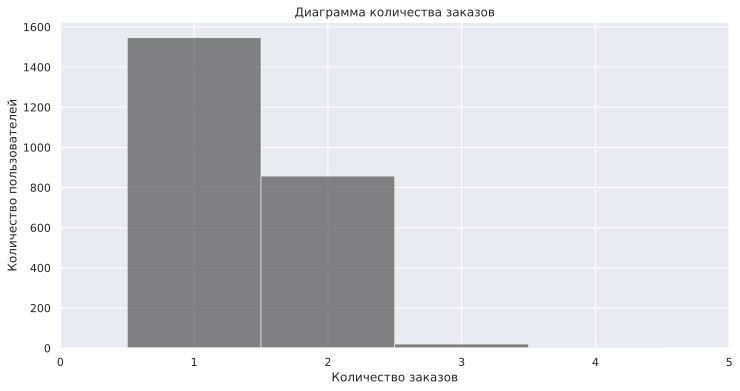

In [27]:
fig = sns.histplot(data=orders.sort_values('order_id', ascending=False),
                   x='order_id',
                   color='#5c5c5c',
                   binwidth=1,
                   discrete=True)
                    
fig.set(xlabel='Количество заказов',
        ylabel='Количество пользователей',
        title='Диаграмма количества заказов',
        xlim=(0,5))

plt.show()

<div style="border: 1px solid; padding: 15px;">
    
За 16 месяцев 1546 пользователей сделали только 1 заказ. Два заказа оформили 857 человек. Количество постоянных клиентов мало, сделавших 3 и более заказа составляет только 28 человек. Особенно сильно выбивается клиент оформивший 126 заказов.

### Категории товаров

In [28]:
sorted(data['product'].unique().tolist())

['tepмокружка avex freeflow 700 мл зеленый avex0759',
 'tepмокружка avex freeflow 700 мл сталь avex0776',
 'tepмокружка avex recharge 500 мл голубой avex0681',
 'автоматическая щетка leifheit для мытья окон с ручкой 43 см. 51114',
 'агератум рассада однолетних цветов в кассете по 10 шт',
 'адиантум лиза d-12 см',
 'азалия индика биколор d-12 см',
 'азалия индика биколор d-12 см h-20',
 'азалия индика розовая d-12 см h-20',
 'азалия индика фиолетовая d-10 см h-20',
 'аквилегия махровая тауэр смесь окрасок объем 1 л',
 'аквилегия обыкновенная барлоу микс объем 1 л',
 'алиссум (лобулярия) снежные одежды 0,2 г 4650091480302',
 'алиссум рассада однолетних цветов в кассете по 10 шт',
 'алиссум рассада однолетних цветов в кассете по 6 шт',
 'алиссум скальный желтый объем 1 л',
 'алоэ вера d-12 см h-25 см',
 'альбука спиралис фризл-сизл d-12 см',
 'амариллис red lion темно-красный в горшке d-12 см 1 луковица',
 'анемона белый объем 0,5 л',
 'антижир posh one magnum 828 мл россия 4580390-927058

<div style="border: 1px solid; padding: 15px;">
    
Заметим, что основная информация для многих позиций содержится в первых двух словах. Также необходимо провести замену буквы `ё` на `e` и привести все слова к именительному падежу. Все действия будем проводить с копированым датасетом.

In [29]:
# Делаем копию
data_copy = data.copy()
print(id(data) == id(data_copy))
data_copy

False


date                           customer_id  order_id  \
0    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...                  ...                                   ...       ...   
5549 2020-01-30 21:00:00  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
5550 2020-01-30 22:00:00  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
5551 2020-01-31 02:00:00  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
5552 2020-01-31 12:00:00  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
5553 2020-01-31 15:00:00  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                product  quantity  price  \
0       комнатное растение в горшке алое вера, d12, h30         1    142   
1     комнатное растение в горшке кофе арабика, d12,...         1    194   
2                           радермахера d-12 см h-20 см         1    112   
3                      хризолидокарпус лутесценс d-9 см         1    179   
4                        циперус зумула d-12 см h-25 см         1    112   
...                                                 ...       ...    ...   
5549  томата (помидор) черниченский черри № 116 сорт...         2     38   
5550         дендробиум санок анна грин 1 ствол d-12 см         1    869   
5551  подставка для обуви резиновая attribute 80x40 ...         1    354   
5552  тагетис крупноцветковый рассада однолетних цве...         1    128   
5553  вешалка для блузок 41 см красный attribute ahm781         1    104   

      value  
0       142  
1       194  
2       112  
3       179  
4       112  
...     ...  
5549     76  
5550    869  
5551    354  
5552    128  
5553    104  

[5554 rows x 7 columns]

In [30]:
stop_words = ['с', 'со', 'для', 'в', 'диам.', 
              'см', 'ripple', '2-х', '3-х', '4-х'
              'на']

In [31]:
m = Mystem()
def words_change(words):
    words.replace('ё', 'е')
    words = words.split()
    
    #Убираем стоп-слова
    words = [word for word in words if word not in stop_words]
    
    #Проверяем, что в последнем слове нет цифр
    if any(ch.isdigit() for ch in words[-1]):
        words = words[:-1]
    words = ' '.join(words)
    
    #Убираем падежи
    words = m.lemmatize(words)
    words = ''.join(words)
    
    
    return words[:-1]

In [32]:
data_copy['product'] = data_copy['product'].apply(words_change)
data_copy

date                           customer_id  order_id  \
0    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...                  ...                                   ...       ...   
5549 2020-01-30 21:00:00  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
5550 2020-01-30 22:00:00  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
5551 2020-01-31 02:00:00  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
5552 2020-01-31 12:00:00  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
5553 2020-01-31 15:00:00  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                product  quantity  price  \
0             комнатный растение горшок алый вера, d12,         1    142   
1          комнатный растение горшок кофе арабика, d12,         1    194   
2                                       радермахер d-12         1    112   
3                             хризолидокарпус лутесценс         1    179   
4                                    циперус зумул d-12         1    112   
...                                                 ...       ...    ...   
5549  томат (помидор) черниченский черри № 116 сорт ...         2     38   
5550                 дендробиум санки анна грин 1 ствол         1    869   
5551          подставка обувь резиновый attribute 80x40         1    354   
5552  тагетис крупноцветковый рассада однолетний цве...         1    128   
5553                вешалка блузка 41 красный attribute         1    104   

      value  
0       142  
1       194  
2       112  
3       179  
4       112  
...     ...  
5549     76  
5550    869  
5551    354  
5552    128  
5553    104  

[5554 rows x 7 columns]

In [33]:
print(f"Количество уникальных товаров после обработки: {data_copy['product'].nunique()}\
        \nдо обработки: {data['product'].nunique()}")

Количество уникальных товаров после обработки: 2311        
до обработки: 2341


In [34]:
dataset = []
for words in data_copy['product']:    
    words.replace('ё', 'е')
    words = words.split()[:1]
    
    #Убираем стоп-слова
    words = [word for word in words if word not in stop_words]

    words = ' '.join(words)
    
    #Убираем падежи
    words = m.lemmatize(words)
    words = ''.join(words)
    dataset.append(words[:-1])
    
print(f"Количество уникальных товаров после обработки: {len(list(set(dataset)))}\
        \nдо обработки: {data['product'].nunique()}")

sorted(list(set(dataset)))

Количество уникальных товаров после обработки: 443        
до обработки: 2341


['tepмокружка',
 'автоматический',
 'агератум',
 'адиантум',
 'азалия',
 'аквилегия',
 'алиссум',
 'алоэ',
 'альбук',
 'амариллис',
 'анемон',
 'антижир',
 'антинакипин',
 'антуриум',
 'аптение',
 'арбуз',
 'аргирантерум',
 'ароматизированный',
 'артемизия',
 'аспарагус',
 'астра',
 'афеляндр',
 'бадан',
 'базилик',
 'бак',
 'баклажан',
 'бакоп',
 'бальзам',
 'бальзамин',
 'банка',
 'барвинок',
 'бархатцы',
 'бегония',
 'бельевой',
 'бензин',
 'бидон',
 'блюдо',
 'блюдце',
 'буддло',
 'бузульник',
 'бульонница',
 'ваза',
 'вакуумный',
 'валериана',
 'ванна',
 'вантуз',
 'ведро',
 'веник',
 'венчик',
 'вербейник',
 'вербена',
 'веревка',
 'вероника',
 'весы',
 'вешалка',
 'вешалка-перекладина',
 'вешалка-плечики',
 'вешалка-стойка',
 'вешалка-сушилка',
 'вигна',
 'вилка',
 'виола',
 'вкладыш',
 'газание',
 'гайлардий',
 'гардения',
 'гвоздик',
 'георгин',
 'герань',
 'гербера',
 'гиацинт',
 'гимнокалициум',
 'гиностемма',
 'гипоаллергенный',
 'гипсофил',
 'гладильный',
 'глоксиния',
 'г

<div style="border: 1px solid; padding: 15px;">
    
Разделим товары на 5 категорий:
    
1. Товары для огорода и сада
1. Товары для кухни
1. Электротовары
1. Товары для ремонта
1. Товары для дома

In [35]:
ogorod = ['азалия', 'адиантум', 'рассада', 'аквилегия', 'алиссум', 'алоэ вера', 'альбук', 'амариллис', 'анемон', 'антуриум',
         'аптение', 'арбуз', 'артемизия', 'аспарагус', 'астра', 'афеляндра', 'бадан', 'базилик', 'баклажан', 'бакоп',
         'бальзамин', 'барвинок', 'бархатцы', 'бегония', 'буддло', 'бузульник', 'вербейник', 'вербена', 'вероника', 'вигна',
         'виола', 'газание', 'гайлардий', 'гардения', 'гвоздик', 'георгин', 'герань', 'гербера', 'гиацинт', 'гимнокалициум',
         'гиностемма', 'гипсофил', 'глоксиния', 'годеция', 'горох', 'гортензия', 'дендробиум', 'джункус', 'драцена', 'душица',
         'дыня', 'ель', 'замиокулькас', 'зверобой', 'земляника', 'змееголовник', 'кабачок', 'каланхое', 'калатея', 'календула',
         'калибрахоа', 'калла', 'каллун', 'калоцефалус', 'капсикум', 'капуста', 'клен', 'клубника', 'кодонант', 'колеус', 'кореопсис',
         'кориандр', 'лаванда', 'лаватер', 'лавр', 'лапчатка', 'левка', 'лен', 'лилейник', 'лобелия', 'многолетний', 'монарда',
         'настурция', 'нивянник', 'осина', 'папоротник', 'пеларгония', 'петуния', 'пиретрум', 'платикодон', 'ранункулус',
         'роза', 'рудбекия', 'седум', 'солидаго', 'томат', 'тюльпан', 'физостегия', 'флокс', 'фуксия', 'хоста', 'хризантема',
         'энотера', 'эхинацея', 'ясколка', 'нолина', 'растение', 'томат', 'радермахер', 'юкка', 'петрушка', 'котовник',
         'эхеверие', 'цинния', 'пуансеттия', 'хризолидокарпус', 'циперус', 'шеффлер', 'эвкалипт', 'кампануть', 'хлорофитум',
         'цикламен', 'тимьян', 'роза', 'примула', 'укроп', 'фиалка', 'незабудка', 'ранункулус', 'сантолина', 'салат',
         'мирт', 'цикламен', 'хлорофитум', 'мирт', 'декабрист', 'иссоп', 'молодило', 'мелисса', 'розмарин', 'цветок',
         'молодить', 'огурец', 'косметь', 'эхинокактус', 'мята', 'лантан', 'крассула', 'мимоза', 'соланум', 'нефролепис', 
         'морковь', 'эшшольция', 'подсолнечник', 'кипарисовик', 'хамедорей', 'муррайя', 'цитрофортунелла', 'мединилла',
         'скиммия', 'фиттоний', 'спатифиллум', 'фикус', 'крокус', 'кофе', 'эпипремнум', 'чабер', 'пахира', 'колокольчик',
         'пеперомия', 'виноград', 'мускарь', 'кашпо', 'патиссон', 'фатсия', 'монард', 'камнеломка', 'буддлей', 'шалфей',
         'сциндапсус', 'валериана', 'любисток', 'цинерария', 'шалфей', 'импатиенс', 'тыква', 'литопс']

kyhnya = ['tepмокружка', 'банк', 'банка', 'блюдо', 'блюдце', 'бульонница', 'ваза', 'венчик', 'весы', 'вилка', 'картофелемялка',
         'кастрюля', 'ковш', 'котел', 'кружка', 'крышка', 'кувшин', 'кухонный', 'ложка', 'антинакипин', 'антижир', 'средство', 
          'мытье','губка', 'мыло', 'перчатка', 'полотенце', 'противень', 'мини-сковорода', 'миска', 'мука', 'нож','овощечистка', 
          'овсянница', 'орехоколка', 'отделитель', 'плита', 'половник', 'посуда', 'посудомоечный','рыбочистка', 'салатник', 
          'салфетница', 'сахарница','сито', 'скалка', 'скатерть', 'сковорода', 'соковарка', 'соковыжималка', 'сотейник',
          'стакан', 'столовый','тарелка', 'терка', 'термокружок', 'термос', 'термостакан', 'толкушка', 'тортница', 'фужер', 
          'хлебница', 'чайный', 'выпечка', 'салфетка', 'овощеварка', 'attribute bamboo', 'разделочный', 'продукт', 'мантоварка',
         'бокал', 'кекс', 'пресс', 'контейнер', 'яйцо', 'пряный', 'кондитерский', 'чайник',] 

electronika =['кипятильник', 'кондиционер','светильник', 'плита', 'электроштопор',  'утюг', 'фен','автополив',
              'миксер', 'свч',  'электрический']

remont = ['лестница','лестница-стремянка','насадка-моп','шило','шпагат', 'болт', 'штангенциркуль', 'зажигалка', 'петля',
          'сварка', 'карниз', 'вентиляционный', 'шпингалет','инструмент', 'напильник', 'сверло', 'фиксатор-шар','ящик',
          'сверло-фреза','стремянка', 'крепеж']

dom = ['щетка leifheit', 'бак', 'вантуз', 'ведро', 'веник', 'веревка', 'вешалка', 'вешалка-перекладина', 'вешалка-плечики', 
       'вешалка-стойка', 'вешалка-сушилка', 'глажение','ерш', 'кисточка', 'ключница', 'ковер', 'коврик', 'комод', 'корзина', 
       'корзинка', 'короб', 'коробка', 'корыто', 'мусор', 'мусорный','гладильный', 'засор', 'зубной', 'известковый',
       'искусственный', 'искуственный', 'комнатный','кофр','крючок', 'лоток','мыло-скраб','муляж', 'наволочка', 'наматрацник', 
       'наматрицник-чехол', 'наматрасник',  'одеяло', 'окномойка', 'отбеливатель','плед', 'плечики', 'сушилка', 
       'подголовник', 'пододеяльник', 'подрукавник', 'подушка', 'покрывало', 'пол',  'постельный', 'прищепок', 'простыня', 
       'пыль', 'пятно','скребок', 'совок', 'стиральный', 'стирка', 'таз', 'ткань', 'тряпка','тряпкодержатель', 'бидон',
       'туалет', 'туалетный', 'увлажнять', 'унитаз', 'унитазный','фоторамка','халат', 'хранение', 'цикламен,', 'чехол', 
       'швабра', 'щетка', 'щетка-утюжок',  'штора', 'ванна', 'вантуз', 'ваза', 'хозяйственный', 'обувница', 'пуф','шнур',
       'щетка-сметка',  'обувь',  'сумка',  'фал', 'тележка', 'свереть', 'термометр',  'урна', 'линейка', 'ручка-скоба', 'ролик']

In [36]:
def category(product):
    if any(i in product for i in electronika):
        return 'Электротовары'
    elif any(i in product for i in kyhnya):
        return 'Товары для кухни'
    elif any(i in product for i in remont):
        return 'Товары для ремонта'
    elif any(i in product for i in dom):
        return 'Товары для дома'
    elif any(i in product for i in ogorod):
        return 'Товары для огорода и сада'

In [37]:
data_copy['category'] = data_copy['product'].apply(category)

data_copy['category'].isna().sum()

0

<div style="border: 1px solid; padding: 15px;">
    
Добавим столбец `category`, в котором будет указана категория товара

In [38]:
data['category'] = data_copy['category']
data

date                           customer_id  order_id  \
0    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...                  ...                                   ...       ...   
5549 2020-01-30 21:00:00  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
5550 2020-01-30 22:00:00  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
5551 2020-01-31 02:00:00  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
5552 2020-01-31 12:00:00  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
5553 2020-01-31 15:00:00  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                product  quantity  price  \
0       комнатное растение в горшке алое вера, d12, h30         1    142   
1     комнатное растение в горшке кофе арабика, d12,...         1    194   
2                           радермахера d-12 см h-20 см         1    112   
3                      хризолидокарпус лутесценс d-9 см         1    179   
4                        циперус зумула d-12 см h-25 см         1    112   
...                                                 ...       ...    ...   
5549  томата (помидор) черниченский черри № 116 сорт...         2     38   
5550         дендробиум санок анна грин 1 ствол d-12 см         1    869   
5551  подставка для обуви резиновая attribute 80x40 ...         1    354   
5552  тагетис крупноцветковый рассада однолетних цве...         1    128   
5553  вешалка для блузок 41 см красный attribute ahm781         1    104   

      value                   category  
0       142            Товары для дома  
1       194            Товары для дома  
2       112  Товары для огорода и сада  
3       179  Товары для огорода и сада  
4       112  Товары для огорода и сада  
...     ...                        ...  
5549     76  Товары для огорода и сада  
5550    869  Товары для огорода и сада  
5551    354            Товары для дома  
5552    128  Товары для огорода и сада  
5553    104            Товары для дома  

[5554 rows x 8 columns]

<div style="border: 1px solid; padding: 15px;">
    
Исследуем продажи товаров различных категорий

In [39]:
data.groupby('category', as_index=False)['quantity'].sum().sort_values('quantity', ascending=False)

category  quantity
0            Товары для дома      7791
2  Товары для огорода и сада      3786
1           Товары для кухни      1975
3         Товары для ремонта       739
4              Электротовары        62

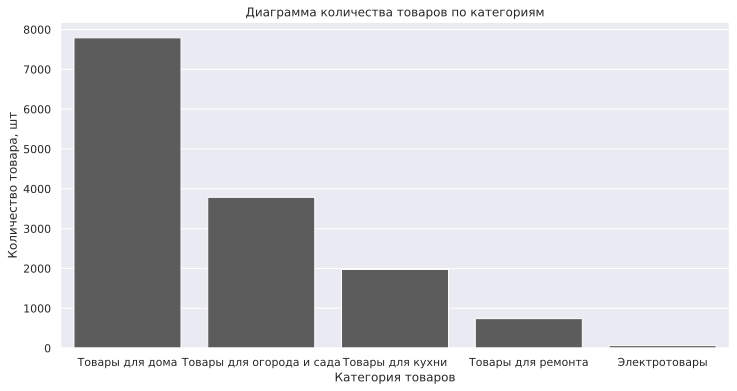

In [40]:
fig = sns.barplot(data=(data.groupby('category', as_index=False)['quantity'].sum()
                            .sort_values('quantity', ascending=False)),
                      x='category',
                      y='quantity',
                      color='#5c5c5c')
                    
fig.set(xlabel='Категория товаров',
        ylabel='Количество товара, шт',
        title='Диаграмма количества товаров по категориям')

plt.show()

<div style="border: 1px solid; padding: 15px;">

Больше всего продаж приходится на категории товары для огорода и сада и товары для дома. Количество проданного на эти 2 категории товара составляет 80% от всего проданного товара.

In [41]:
data.groupby('category', as_index=False)['order_id'].nunique().sort_values('order_id', ascending=False)

category  order_id
0            Товары для дома      2004
2  Товары для огорода и сада       990
1           Товары для кухни       548
3         Товары для ремонта       121
4              Электротовары        42

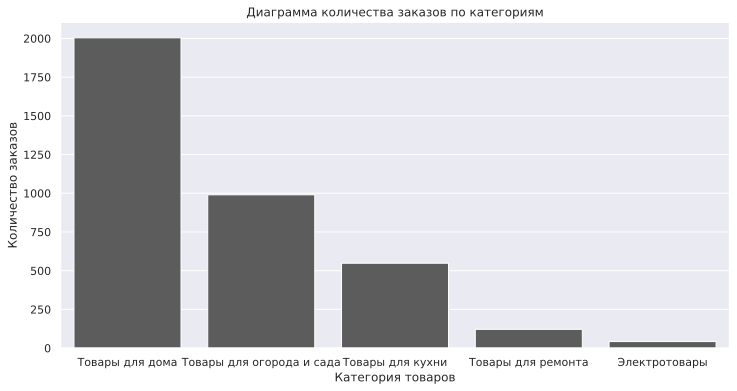

In [42]:
fig = sns.barplot(data=(data.groupby('category', as_index=False)['order_id'].nunique()
                            .sort_values('order_id', ascending=False)),
                      x='category',
                      y='order_id',
                      color='#5c5c5c')
                    
fig.set(xlabel='Категория товаров',
        ylabel='Количество заказов',
        title='Диаграмма количества заказов по категориям')

plt.show()

<div style="border: 1px solid; padding: 15px;">

Больше всего заказов приходится также на категории товары для огорода и сада и товары для дома. Заметим, что все категории товаров располагаются в том же порядке, что и на прошлом графике. Следовательно, количество аномальных заказов с большим количеством товара минимально.

### Определение выбросов

<div style="border: 1px solid; padding: 15px;">

Исследуем причины большой разницы между средним и медианным значениями

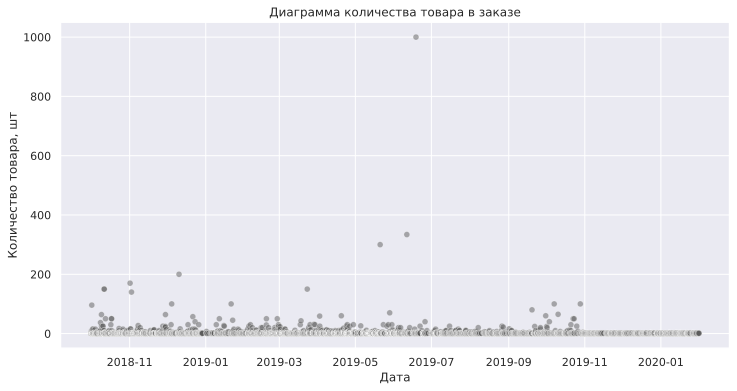

In [43]:
fig = sns.scatterplot(data=data,
                      x='date',
                      y='quantity',
                      alpha=0.5,
                      color='#5c5c5c')
                    
                    
fig.set(xlabel='Дата',
        ylabel='Количество товара, шт',
        title='Диаграмма количества товара в заказе')

plt.show()

<div style="border: 1px solid; padding: 15px;">

Большинство заказов оформляется с единичной позицией товара, но имеются позиции с количеством товараза за заказ больше 100. Сильнее всего выделяется заказ в 1000 единиц. После декабря 2019 года пользователи сугубо берут по 1-2 единице товара.

In [44]:
#Найдем id пользователя, заказавшего 1000 единиц товара
spetial_customer = data.query('quantity==1000')
spetial_customer

date                           customer_id  order_id  \
3797 2019-06-18 15:00:00  312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6     71743   

                                                product  quantity  price  \
3797  вантуз с деревянной ручкой d14 см красный, bur...      1000    675   

       value         category  
3797  675000  Товары для дома

<div style="border: 1px solid; padding: 15px;">
    
В качестве покупки на 1000 единиц выступил заказ на вантузы. Данный пользователь произвел только этот заказ. Для дальнейшего анализа исключим этого пользователя, так как он будет вносить большой шум.

In [45]:
data = data.query('customer_id != @spetial_customer.customer_id.tolist()').reset_index(drop=True)
data

date                           customer_id  order_id  \
0    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...                  ...                                   ...       ...   
5548 2020-01-30 21:00:00  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
5549 2020-01-30 22:00:00  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
5550 2020-01-31 02:00:00  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
5551 2020-01-31 12:00:00  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
5552 2020-01-31 15:00:00  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                product  quantity  price  \
0       комнатное растение в горшке алое вера, d12, h30         1    142   
1     комнатное растение в горшке кофе арабика, d12,...         1    194   
2                           радермахера d-12 см h-20 см         1    112   
3                      хризолидокарпус лутесценс d-9 см         1    179   
4                        циперус зумула d-12 см h-25 см         1    112   
...                                                 ...       ...    ...   
5548  томата (помидор) черниченский черри № 116 сорт...         2     38   
5549         дендробиум санок анна грин 1 ствол d-12 см         1    869   
5550  подставка для обуви резиновая attribute 80x40 ...         1    354   
5551  тагетис крупноцветковый рассада однолетних цве...         1    128   
5552  вешалка для блузок 41 см красный attribute ahm781         1    104   

      value                   category  
0       142            Товары для дома  
1       194            Товары для дома  
2       112  Товары для огорода и сада  
3       179  Товары для огорода и сада  
4       112  Товары для огорода и сада  
...     ...                        ...  
5548     76  Товары для огорода и сада  
5549    869  Товары для огорода и сада  
5550    354            Товары для дома  
5551    128  Товары для огорода и сада  
5552    104            Товары для дома  

[5553 rows x 8 columns]

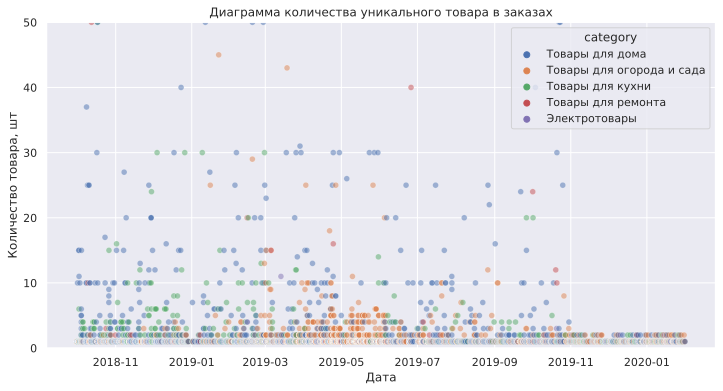

In [46]:
fig = sns.scatterplot(data=data,
                      x='date',
                      y='quantity',
                      hue='category',
                      alpha=0.5,)
                    
                    
fig.set(xlabel='Дата',
        ylabel='Количество товара, шт',
        title='Диаграмма количества уникального товара в заказах',
        ylim=(0, 50))

plt.show()

<div style="border: 1px solid; padding: 15px;">

Чаше всего товар заказывают в количетсве от 1 до 4 штук. Выделем товары с заказом больше 4 на одну позицию как оптовые.
Также видно, что в опт закупаются товарами больше всего из категории товары для дома. Что неудивительно, так как данная категория самая многочисленная.

In [47]:
pd.set_option("display.max_rows", 10)
data['wholesale'] = data['quantity'].apply(lambda x: 1 if x>4 else 0)
data[data['wholesale']==1].sort_values('quantity')

date                           customer_id  order_id  \
1069 2018-12-16 23:00:00  3f25cb2b-1d98-442e-b688-b56eab16f592     69396   
867  2018-11-27 10:00:00  7d91d2e0-0f18-4cc4-bb58-d2a4115a2caf     69124   
3338 2019-05-19 15:00:00  82eb3913-2c17-4935-8d1a-bbb10ac2bb48     14795   
819  2018-11-23 20:00:00  278cffb9-4414-449a-8cb8-ffdbef1bf1d8     69100   
3396 2019-05-22 13:00:00  29655d47-d948-4b42-aeb9-2c10cc8fc09c     14809   
...                  ...                                   ...       ...   
2060 2019-03-23 10:00:00  685d3d84-aebb-485b-8e59-344b3df8b3d3     70841   
484  2018-11-01 08:00:00  aa42dc38-780f-4b50-9a65-83b6fa64e766     68815   
1013 2018-12-10 14:00:00  a984c5b7-ff7e-4647-b84e-ef0b85a2762d     69289   
3365 2019-05-20 21:00:00  5d189e88-d4d6-4eac-ab43-fa65a3c4d106     71478   
3730 2019-06-11 07:00:00  146cd9bf-a95c-4afb-915b-5f6684b17444     71668   

                                                product  quantity  price  \
1069  банка стеклянная с крышкой attribute fleur 650...         5    149   
867   скатерть прямоугольная ажурная marine 132х177 ...         5    899   
3338                            хоста микс объем 0,75 л         5    225   
819     плечики пластмассовые размер 48 - 54 мп 1205160         5     22   
3396  пеларгония зональная диам. 12 см малиново-крас...         5    150   
...                                                 ...       ...    ...   
2060  плечики пластмассовые размер 52 - 54 тула 1205158       150     20   
484                           муляж яблоко 9 см красное       170     51   
1013      ручка-скоба рс-100 белая *трибатрон*, 1108035       200     29   
3365                          муляж яблоко 9 см красное       300     51   
3730   вешалки мягкие для деликатных вещей 3 шт шоколад       334    148   

      value                   category  wholesale  
1069    745           Товары для кухни          1  
867    4495           Товары для кухни          1  
3338   1125  Товары для огорода и сада          1  
819     110            Товары для дома          1  
3396    750  Товары для огорода и сада          1  
...     ...                        ...        ...  
2060   3000            Товары для дома          1  
484    8670            Товары для дома          1  
1013   5800            Товары для дома          1  
3365  15300            Товары для дома          1  
3730  49432            Товары для дома          1  

[367 rows x 9 columns]

<div style="border: 1px solid; padding: 15px;">
    
В заказы для оптового сегмента попало 367 записей.

In [48]:
retail = data[data['wholesale']==0]
retail

date                           customer_id  order_id  \
0    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...                  ...                                   ...       ...   
5548 2020-01-30 21:00:00  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
5549 2020-01-30 22:00:00  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
5550 2020-01-31 02:00:00  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
5551 2020-01-31 12:00:00  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
5552 2020-01-31 15:00:00  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                product  quantity  price  \
0       комнатное растение в горшке алое вера, d12, h30         1    142   
1     комнатное растение в горшке кофе арабика, d12,...         1    194   
2                           радермахера d-12 см h-20 см         1    112   
3                      хризолидокарпус лутесценс d-9 см         1    179   
4                        циперус зумула d-12 см h-25 см         1    112   
...                                                 ...       ...    ...   
5548  томата (помидор) черниченский черри № 116 сорт...         2     38   
5549         дендробиум санок анна грин 1 ствол d-12 см         1    869   
5550  подставка для обуви резиновая attribute 80x40 ...         1    354   
5551  тагетис крупноцветковый рассада однолетних цве...         1    128   
5552  вешалка для блузок 41 см красный attribute ahm781         1    104   

      value                   category  wholesale  
0       142            Товары для дома          0  
1       194            Товары для дома          0  
2       112  Товары для огорода и сада          0  
3       179  Товары для огорода и сада          0  
4       112  Товары для огорода и сада          0  
...     ...                        ...        ...  
5548     76  Товары для огорода и сада          0  
5549    869  Товары для огорода и сада          0  
5550    354            Товары для дома          0  
5551    128  Товары для огорода и сада          0  
5552    104            Товары для дома          0  

[5186 rows x 9 columns]

### Определение динамики выручки

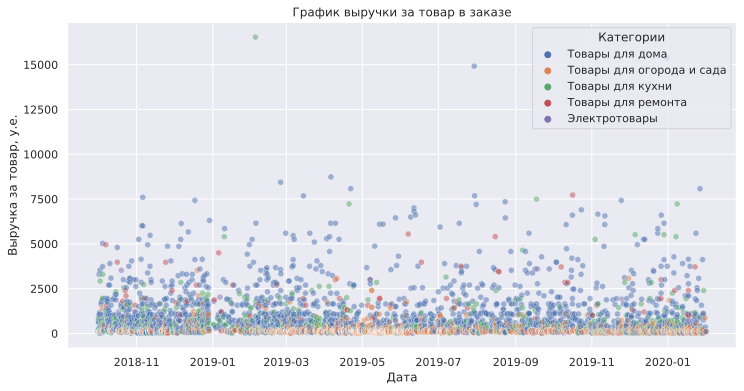

In [49]:
fig = sns.scatterplot(data=retail,
                   x='date', 
                   y='value',
                   alpha=0.5,
                   hue='category')

fig.set(xlabel='Дата',
        ylabel='Выручка за товар, у.е.',
        title='График выручки за товар в заказе')

plt.legend(title='Категории')
plt.show()

<div style="border: 1px solid; padding: 15px;">
    
Большинство товаров в заказе покупается на сумму меньше 1000 у.е. Большинство товаров с суммой больше 2500 рублей в заказе приходится на категорию товары для дома.

In [50]:
#Добавим столбец с годом и месяцем, со временем и с днем недели
data['y_m'] = data['date'].dt.strftime('%Y-%m')
data['hours'] = data['date'].dt.strftime('%H')
data['week'] = data['date'].dt.strftime("%A")


"""receipt = (pd.pivot_table(data, 
                          index='order_id', 
                          values=['product', 'value'], 
                          aggfunc={'product':'count', 'value':'sum'})
             .reset_index())
receipt['avg_order'] = (receipt['value'] / receipt['product']).astype(int)
receipt = receipt[['order_id', 'avg_order']]"""

# Столбец со суммой заказа
receipt = data.groupby('order_id', as_index=False)['value'].sum().rename(columns={'value':'revenue'})
data = pd.merge(data, receipt, how="left", on=["order_id"])

#Проверим данные
retail = data[data['wholesale']==0]
data

date                           customer_id  order_id  \
0    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...                  ...                                   ...       ...   
5548 2020-01-30 21:00:00  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
5549 2020-01-30 22:00:00  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
5550 2020-01-31 02:00:00  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
5551 2020-01-31 12:00:00  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
5552 2020-01-31 15:00:00  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                product  quantity  price  \
0       комнатное растение в горшке алое вера, d12, h30         1    142   
1     комнатное растение в горшке кофе арабика, d12,...         1    194   
2                           радермахера d-12 см h-20 см         1    112   
3                      хризолидокарпус лутесценс d-9 см         1    179   
4                        циперус зумула d-12 см h-25 см         1    112   
...                                                 ...       ...    ...   
5548  томата (помидор) черниченский черри № 116 сорт...         2     38   
5549         дендробиум санок анна грин 1 ствол d-12 см         1    869   
5550  подставка для обуви резиновая attribute 80x40 ...         1    354   
5551  тагетис крупноцветковый рассада однолетних цве...         1    128   
5552  вешалка для блузок 41 см красный attribute ahm781         1    104   

      value                   category  wholesale      y_m hours      week  \
0       142            Товары для дома          0  2018-10    00    Monday   
1       194            Товары для дома          0  2018-10    00    Monday   
2       112  Товары для огорода и сада          0  2018-10    00    Monday   
3       179  Товары для огорода и сада          0  2018-10    00    Monday   
4       112  Товары для огорода и сада          0  2018-10    00    Monday   
...     ...                        ...        ...      ...   ...       ...   
5548     76  Товары для огорода и сада          0  2020-01    21  Thursday   
5549    869  Товары для огорода и сада          0  2020-01    22  Thursday   
5550    354            Товары для дома          0  2020-01    02    Friday   
5551    128  Товары для огорода и сада          0  2020-01    12    Friday   
5552    104            Товары для дома          0  2020-01    15    Friday   

      revenue  
0        1037  
1        1037  
2        1037  
3        1037  
4        1037  
...       ...  
5548       76  
5549      869  
5550      354  
5551      128  
5552      104  

[5553 rows x 13 columns]

<div style="border: 1px solid; padding: 15px;">

Новые столбцы коректны

In [51]:
#Динамика дохода за весь период для розницы
pd.set_option("display.max_rows", 16)
retail.pivot_table(index='y_m',values='value',aggfunc='sum').style.background_gradient('coolwarm')

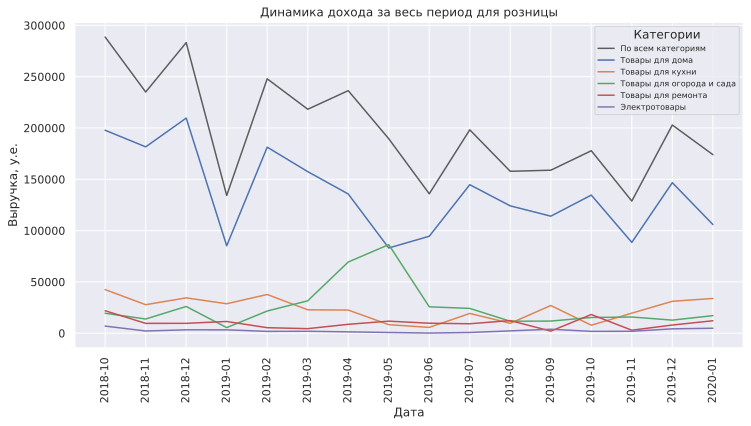

In [52]:
fig = sns.lineplot(data=retail.pivot_table(index='y_m',values='value',aggfunc='sum'),
                   x='y_m', 
                   y='value',
                   color='#5c5c5c',
                   label='По всем категориям')

fig = sns.lineplot(data=retail.groupby(['y_m', 'category'], as_index=False)['value'].sum(),
                   x='y_m', 
                   y='value',
                   hue='category')

fig.set(xlabel='Дата',
        ylabel='Выручка, у.е.',
        title='Динамика дохода за весь период для розницы')

plt.legend(title='Категории', fontsize = "8")
plt.xticks(rotation=90)
plt.show()

<div style="border: 1px solid; padding: 15px;">
    
На протяжении всего периода времени выручка с продаж падала, начиная с **280000 у.е. в октябре 2018 года** выручка к концу временного прометка снизилась до **180000 у.е. к январю 2020 года**. Особенно сильно выделяются 2 обвала:
    
1. В январе 2019 года. Данный обвал связан с понижением покупок по категории товары для дома. Это может быть связано с праздниками.
1. В ююне 2019 года. Причины этого падения выручки связаны с окончанием сезонных покупок по категории товары для огорода и дома и тем, что продажи по категории товары для дома не успели вернуться после весеннего падения.

Если говорить в разрезе категорий, то можно выделить сезонность у товаров для огорода и сада. Товары этой категории пользуются спросом с марта по май. Товары для дома приносят основной доход, продажи товаров для дома имеют спад в начале лета. Другие категории не имеют ярко выраженных сезонных особенностей.

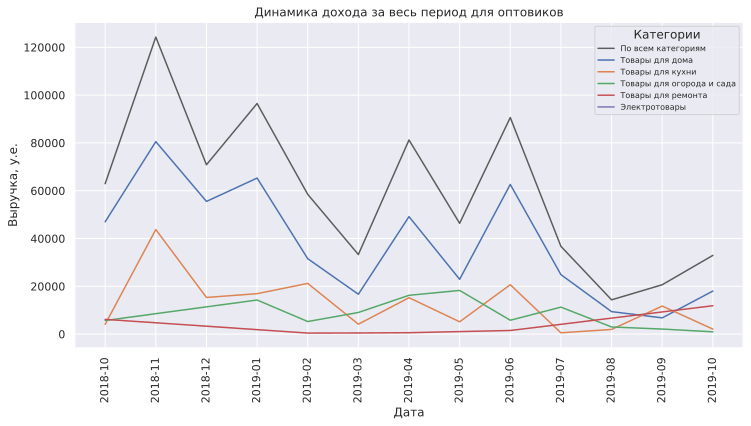

In [53]:
fig = sns.lineplot(data=(data.query('wholesale == 1')
                             .pivot_table(index='y_m',values='value',aggfunc='sum')),
                   x='y_m', 
                   y='value',
                   color='#5c5c5c',
                   label='По всем категориям')

fig = sns.lineplot(data=(data.query('wholesale == 1')
                            .groupby(['y_m', 'category'], as_index=False)['value'].sum()),
                   x='y_m', 
                   y='value',
                   hue='category')

fig.set(xlabel='Дата',
        ylabel='Выручка, у.е.',
        title='Динамика дохода за весь период для оптовиков')

plt.legend(title='Категории', fontsize = "8")
plt.xticks(rotation=90)
plt.show()

In [54]:
opt = data.query('wholesale == 1').groupby(['y_m', 'category'], as_index=False)['value'].sum()
opt[opt['category']=='Электротовары']

y_m       category  value
19  2019-03  Электротовары   2915

<div style="border: 1px solid; padding: 15px;">
                                         
В рассматривыемых данных отсутствует заказ на 1000 единиц вантузов.

В оптовом сегменте выручка по всем категориям падает **с января по март 2019 года** и **с июня по август 2019 года**. Данные просадки связанны с просадками выручки по категории товары для дома.

Товары для огорода и сада также проявляют сезонный характер, весна является наиболее рентабельным временем в данной категории. 
    
Товарами для ремонта закупаются во второй половине года.
    
Электротовары в больших партиях не закупается

In [55]:
#Рассчет среднего чека по рознице в разрезе по месяцам
avg = (pd.pivot_table(retail, index='y_m', columns='order_id', values='revenue', aggfunc='first')
         .mean(axis=1)
         .reset_index()
         .rename(columns={0:'avg'}))

avg

y_m          avg
0   2018-10  1381.084906
1   2018-11  1533.657609
2   2018-12  1092.144487
3   2019-01   972.542254
4   2019-02   999.816733
5   2019-03  1003.479452
6   2019-04  1053.142241
7   2019-05  1198.203593
8   2019-06   967.678082
9   2019-07  1126.353933
10  2019-08   991.337500
11  2019-09   940.041420
12  2019-10   961.243243
13  2019-11   593.479263
14  2019-12   824.699187
15  2020-01   646.944238

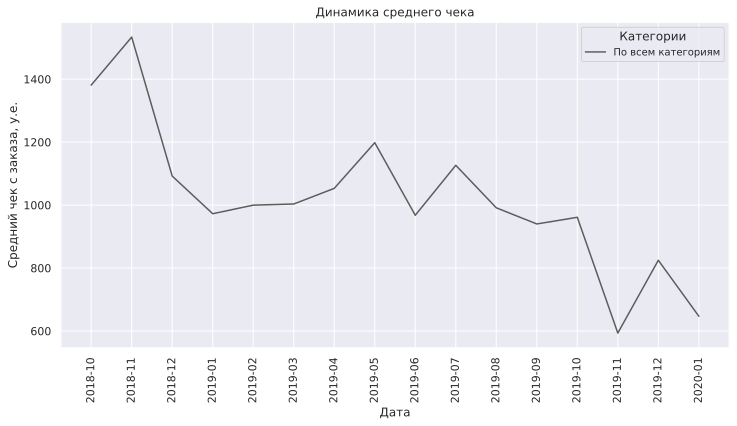

In [56]:
fig = sns.lineplot(data=avg,
                   x='y_m', 
                   y='avg',
                   color='#5c5c5c',
                   label='По всем категориям')

fig.set(xlabel='Дата',
        ylabel='Средний чек с заказа, у.е.',
        title='Динамика среднего чека')

plt.legend(title='Категории', fontsize = "10", loc='upper right')
plt.xticks(rotation=90)
plt.show()

<div style="border: 1px solid; padding: 15px;">
    
После падения в **декабре-январе 2019 года с 1500 у.е. до 1000 у.е.** средний чек откатился в летний период до **1100 у.е.**,но не вернулся к значениям **октября-ноября 2018 года**. 
Наибольший пик в **2019 году** был достигут в **мае**, средний чек был равен **1200 у.е.**. Можно сказать о начале дачного периода.

In [57]:
avg_customer = (pd.pivot_table(data, index='y_m', columns='customer_id', values='value', aggfunc='sum')
                  .mean(axis=1)
                  .reset_index()
                  .rename(columns={0:'avg'}))
avg_customer 

y_m          avg
0   2018-10  1952.977778
1   2018-11  2018.808989
2   2018-12  1512.982906
3   2019-01  1537.966667
4   2019-02  1250.542857
5   2019-03  1084.314655
6   2019-04  1334.462185
7   2019-05  1412.508982
8   2019-06  1500.099338
9   2019-07  1263.075269
10  2019-08  1043.163636
11  2019-09  1037.710983
12  2019-10  1211.350575
13  2019-11   593.479263
14  2019-12   824.699187
15  2020-01   646.944238

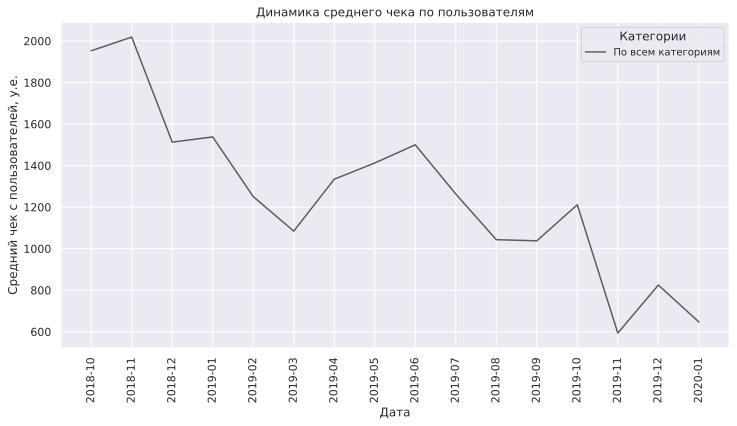

In [58]:
fig = sns.lineplot(data=avg_customer,
                   x='y_m', 
                   y='avg',
                   color='#5c5c5c',
                   label='По всем категориям')

fig.set(xlabel='Дата',
        ylabel='Средний чек с пользователей, у.е.',
        title='Динамика среднего чека по пользователям')

plt.legend(title='Категории', fontsize = "10", loc='upper right')
plt.xticks(rotation=90)
plt.show()

<div style="border: 1px solid; padding: 15px;">
    
Во многом динамика среднего чека по пользователям напоминает средний чек с заказа. Но имеется более ярко выраженный отскок в мае-июне.

### Сегментация пользоватей

 Кластеризацию будем проводить по количеству заказов и по среднему чеку

In [59]:
retail['customer_id'].nunique()

2199

<div style="border: 1px solid; padding: 15px;">
    
Сегментацию будем проводить для 2199 пользователей

In [60]:
# Создаем сет с пользователями и их заказами с суммой этих заказов
cohort = retail.groupby(['customer_id', 'order_id'], as_index=False).agg({'revenue':'first', 'date':'first'})

#Считаем количество заказов, средний чек пользователя по заказам и количество дней с последнего заказа
last_day = data['date'].max()
cohort = cohort.groupby('customer_id').agg({'order_id':'nunique', 
                                            'revenue':'mean',
                                             'date': lambda x: (last_day - x.max()).days})

cohort['order_id'] = cohort['order_id'].apply(lambda x: 1 if x > 1 else 0)

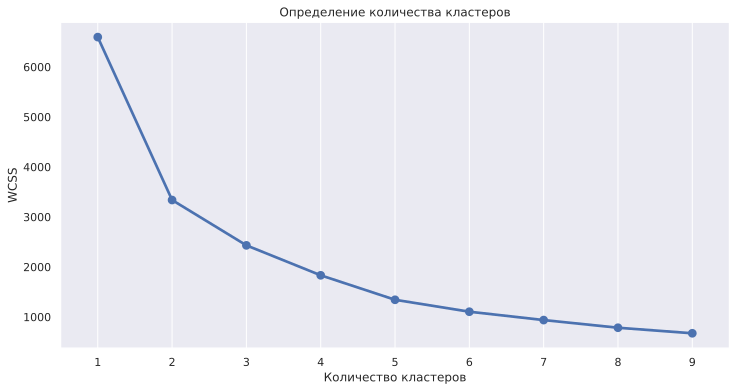

In [61]:
# масштабируем
std_scaler = StandardScaler()
df_std = std_scaler.fit_transform(cohort)
df_std = pd.DataFrame(data = df_std,columns = cohort.columns)

#Записываем ошибки
errors = []
for k in range(1, 10):
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(df_std)
    errors.append(model.inertia_)

    
fig = sns.pointplot(x=list(range(1, 10)), y=errors)

fig.set(xlabel='Количество кластеров',
        ylabel='WCSS',
        title='Определение количества кластеров')

plt.grid()
plt.show()

<div style="border: 1px solid; padding: 15px;">
    
Примем k равное 3.

In [62]:
#Проведение кластеризации
model = KMeans(n_clusters = 3, random_state=0)
model.fit(df_std)
cohort['cluster'] = model.labels_

#Среднии значения кластеров
cohort.groupby('cluster').mean()

order_id      revenue        date
cluster                                   
0        0.011792   846.285710  291.980346
1        1.000000   826.747624   71.153938
2        0.101124  5808.694757  266.831461

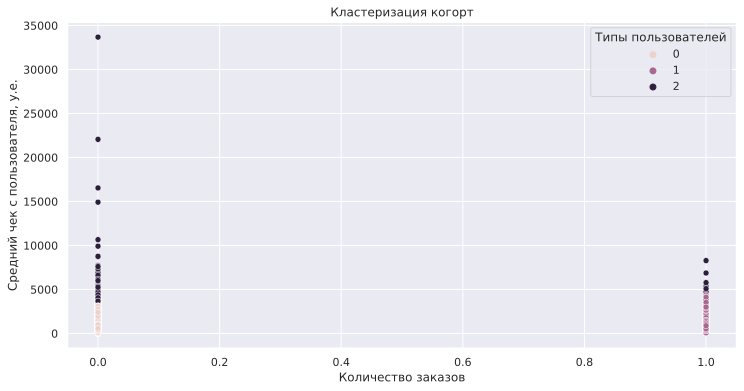

In [63]:
fig = sns.scatterplot(data=cohort,
                x='order_id',
                y='revenue',
                hue='cluster')

fig.set(xlabel='Количество заказов',
        ylabel='Средний чек с пользователя, у.е.',
        title='Кластеризация когорт')


plt.legend(title='Типы пользователей')
plt.show()

<div style="border: 1px solid; padding: 15px;">
    
Можно заметить, что **когорта 2** состоит из **4** пользоватлей с очень большой выручкой при малых продажах. Данные пользователи вносят ошибку кластеризации. Удалим их из выборки и проведем все заново.

In [64]:
cohort.groupby('cluster').mean()

order_id      revenue        date
cluster                                   
0        0.011792   846.285710  291.980346
1        1.000000   826.747624   71.153938
2        0.101124  5808.694757  266.831461

In [65]:
cohort['cluster'].value_counts()

0    1272
1     838
2      89
Name: cluster, dtype: int64

<div style="border: 1px solid; padding: 15px;">

В **группу 0** попали пользователи с выручкой, в среднем на пользователя, в **846 у.е** и **1 заказом**, в среднем на пользователя. Помимо этого с заказа у данной группы прошло **291 день**. Всего эта группа расчитывает **1272 пользователей**. Таким образом, данную категорию пользователей можно характеризовать как **одноразовый низкоприбыльный**
    
В **группу 1** попали пользователи с выручкой, в среднем на пользователя, в **826 у.е**. В этой группе **838 пользователь**. Отличительной характеристикой данной группы является количество заказов, пользователи данной группы заказывают **больше 1 заказа**, также количество дней с последнего заказа составляет **71 день**. Охарактеризуем группу как **постоянный**
    
В **группу 2** попали пользователи с выручкой, в среднем на пользователя, в **5808 у.е**. Группа состоит из **89 пользователей**, которые оформили по **1 заказу**, в среднем на пользователя, и количество **дней** с этого заказа составляет **266**. Данную группу пользоватлей можно охарактеризовать как **одноразовый высокоприбыльный**

In [66]:
# Ставим местки кластера
cohort = cohort.reset_index()
retail = pd.merge(retail, cohort[['cluster', "customer_id"]], how="left", on=["customer_id"])
retail['cluster'] = retail['cluster'].replace({0:"одноразовый низкоприбыльный", 
                                               1:"постоянный", 
                                               2:"одноразовый высокоприбыльный"})

### Исследование сезонности товаров для каждой когорты

In [67]:
low_value = retail[retail['cluster']=="одноразовый низкоприбыльный"].groupby(['y_m', 'category'], as_index=False)['value'].sum()

regular_value = retail[retail['cluster']=="постоянный"].groupby(['y_m', 'category'], as_index=False)['value'].sum()

hight_value = retail[retail['cluster']=="одноразовый высокоприбыльный"].groupby(['y_m', 'category'], as_index=False)['value'].sum()

In [68]:
pd.set_option("display.max_rows", None)
pd.pivot_table(data=retail, columns='cluster', index='y_m', values='value', aggfunc='sum', margins=True)

cluster  одноразовый высокоприбыльный  одноразовый низкоприбыльный  \
y_m                                                                  
2018-10                         44364                       160254   
2018-11                         50797                       109700   
2018-12                         36975                       115296   
2019-01                         13270                        52369   
2019-02                         30745                        72869   
2019-03                         16194                        85025   
2019-04                         51914                        80361   
2019-05                         55630                        81866   
2019-06                         15998                        56002   
2019-07                         49529                        74823   
2019-08                         33706                        61516   
2019-09                         34936                        52351   
2019-10                         48057                        86684   
2019-11                         13982                          782   
2019-12                         15358                          919   
2020-01                          5594                         4065   
All                            517049                      1094882   

cluster  постоянный      All  
y_m                           
2018-10       83957   288575  
2018-11       74565   235062  
2018-12      130895   283166  
2019-01       68564   134203  
2019-02      144282   247896  
2019-03      117046   218265  
2019-04      104102   236377  
2019-05       52027   189523  
2019-06       63886   135886  
2019-07       73843   198195  
2019-08       62552   157774  
2019-09       71580   158867  
2019-10       43089   177830  
2019-11      114021   128785  
2019-12      186599   202876  
2020-01      164369   174028  
All         1555377  3167308

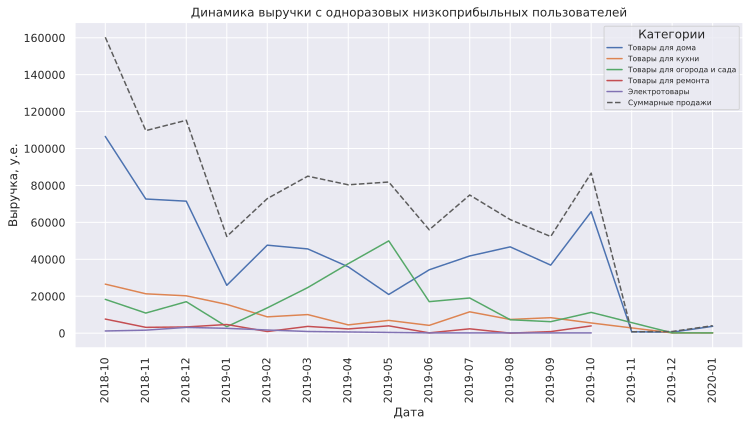

In [69]:
fig = sns.lineplot(data=low_value,
                  x='y_m',
                  y='value',
                  hue='category')

fig = sns.lineplot(data=low_value.groupby('y_m', as_index=False)['value'].sum(),
                  x='y_m',
                  y='value', 
                  label='Суммарные продажи',
                  color='#5c5c5c',
                  linestyle='--')


fig.set(xlabel='Дата',
        ylabel='Выручка, у.е.',
        title='Динамика выручки с одноразовых низкоприбыльных пользователей')

plt.legend(title='Категории', loc='upper right', fontsize = "7.5")
plt.xticks(rotation=90)
plt.show()

<div style="border: 1px solid; padding: 15px;">
    
У **одноразовых низкоприбыльных пользователей** наблюдается спад продаж к январю 2019 года по товарам для дома, для кухни и для огорода и сада. Спад составляет **110 тыс. у.е.**. После января идет небольшой отскок за счет товаров для дома и товаров для огорода и сада. Однако, выручка в четвертом квартале 2019 года падает до **4000 у.е.**
    
Товары для дома после январского спада произвели отскок до **48 тыс у.е.**. В мае имеется небольшой спад, однако затем наблюдается небольшой рост к октябрю до **60 тыс. у.е.**, после которого данная группа перестала покупать товары для дома.
    
Товары для огорода и сада имеют постепенный рост с января по май, выручку в мае составляет **50 тыс. у.е.**. После мая начинается спад.
    
Выручка с товаров для кухни **падает с октября 2018 года по июнь 2019 года**, после наблюдается незначительный отскок с июля по сентябрь 2019 года.
    
Продажи товаров для ремонта и электротоваров незначительны на всем протяжении данных. Однако, с октября 2019 года данные группы товаров не покупаются вообще.
    
Суммарная выручка за весь период составила **1.1 млн у.е.**.

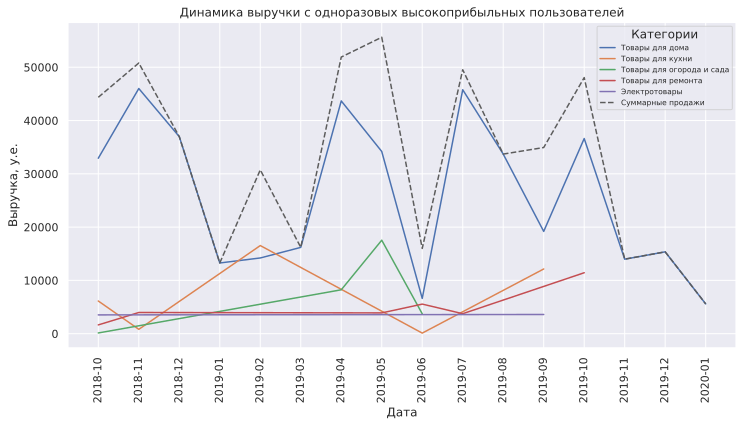

In [70]:
fig = sns.lineplot(data=hight_value,
                  x='y_m',
                  y='value',
                  hue='category')

fig = sns.lineplot(data=hight_value.groupby('y_m', as_index=False)['value'].sum(),
                  x='y_m',
                  y='value', 
                  label='Суммарные продажи',
                  color='#5c5c5c',
                  linestyle='--')

fig.set(xlabel='Дата',
        ylabel='Выручка, у.е.',
        title='Динамика выручки с одноразовых высокоприбыльных пользователей')

plt.legend(title='Категории', loc='upper right', fontsize = "7.5")
plt.xticks(rotation=90)
plt.show()

<div style="border: 1px solid; padding: 15px;">
    
У **одноразовых высокоприбыльных пользователей** также имеется спад продаж в январе 2019 года. Суммарные потери составляют **25 тыс у.е.**. После января идет небольшой отскок за счет товаров для кухни, которые в феврале выручили **15 тыс у.е.**. Также суммарная выручка имеет спад в июле из-за снижения продаж товаров для дома.
    
Товары для дома покупается в октябре, ноябре, в апреле, мае и в июле, августе. Средняя выручка в эти месяцы составляет **40 тыс у.е.**.

Выручка по товарам для огорода и сада как и у **одноразовых низкоприбыльных пользователей** достигает пика в мае месяце, выручка в мае составляет **18 тыс у.е.**. После данная группа не закупает товары данной категории.
   
Выручка товаров для ремонта с октября 2018 года по май 2019 года постояна, и она равняется **5 тыс у.е.** После июля начинается небольшой рост до **11 тыс у.е.** в октябре 2019 года. После октября продажи прекращаются.
    
Электротовары с октября 2018 года по сентябрь 2019 года стабильно продаются в размере **5 тыс. у.е.**

За 16 месяцев с данной группы было выручено **0.5 млн у.е.**

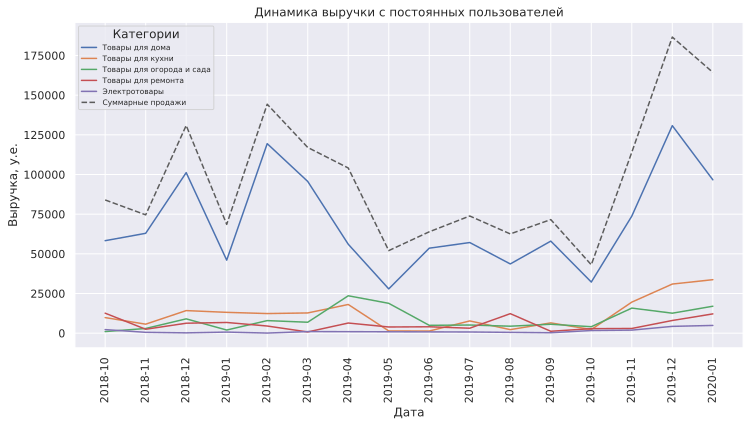

In [71]:
fig = sns.lineplot(data=regular_value,
                  x='y_m',
                  y='value',
                  hue='category')

fig = sns.lineplot(data=regular_value.groupby('y_m', as_index=False)['value'].sum(),
                  x='y_m',
                  y='value', 
                  label='Суммарные продажи',
                  color='#5c5c5c',
                  linestyle='--')

fig.set(xlabel='Дата',
        ylabel='Выручка, у.е.',
        title='Динамика выручки с постоянных пользователей')

plt.legend(title='Категории', loc='upper left', fontsize = "7.5")
plt.xticks(rotation=90)
plt.show()

<div style="border: 1px solid; padding: 15px;">
    
Динамика выручки **постоянных пользователей** имеет пики в декабре 2018 года (130 тыс у.е.) и в феврале (145 тыс у.е.), декабре 2019 года (186 тыс. у.е.) за счет товаров для дома. С юиля по сентябрь выручка с товаров для дома составляет **50 тыс. у.е.**
    
Товары для огорода и сада имеет небольшой рост после января 2019 года по апрель 2019 года, выручка в апреле составляет **25 тыс. у.е.**. После мая выручка падает до **5000 у.е.**, но начиная с ноября 2019 года по январь 2020 года выручка вернулась к **18 тыс у.е.**
    
Товары для кухни продаются с января по март. Средняя выручка составляет 10 тыс у.е.
    
Продажи товаров для ремонта и электротоваров незначительны на всем протяжении данных.
    
За 16 месяцев с данной группы было выручено **1.55 млн у.е.**.

In [72]:
days_hours = (retail.pivot_table(index='hours',columns='week', values='order_id', aggfunc='nunique'))
days_hours = days_hours[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].fillna(0)

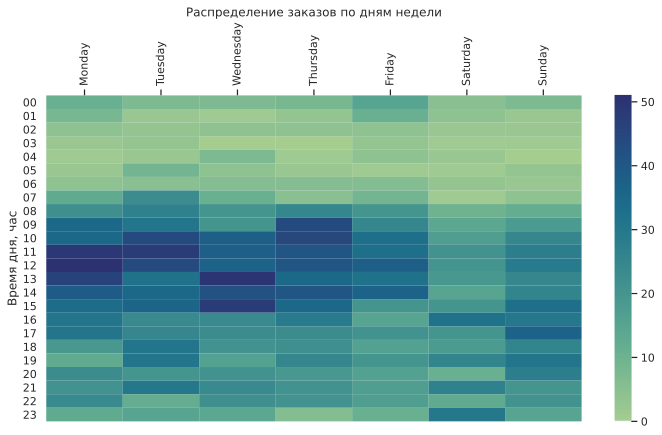

In [73]:
fig = sns.heatmap(data=days_hours, cmap="crest")

fig.set(xlabel='',
        ylabel='Время дня, час',
        title='Распределение заказов по дням недели')
fig.xaxis.tick_top()
plt.xticks(rotation=90)
plt.show()

<div style="border: 1px solid; padding: 15px;">
    
Чаще всего пользователи оформляют заказ в будние дни с 10 до 15 часов. Наиболее "горячими" днями выступают: понедельник, вторник и среда.
    
В субботу заказывают реже всего. В воскресенье стоит производить рассылку после полудня.    

### Вывод

В основном пользователи совершают только 1-2 заказа. Так, за 16 месяцев 1546 пользователей сделали только 1 заказ. Два заказа оформили 857 человек. Количество постоянных клиентов мало, сделавших 3 и более заказа составляет только 28 человек. Причем имеется постоянный клиент, который совершил 126 заказов. Причем большинство товаров в заказе покупается на сумму меньше 1000 у.е.

Средний чек после падения в **декабре-январе 2019 года с 1500 у.е. до 1000 у.е.** откатился в летний период до **1100 у.е.**,но не вернулся к значениям **октября-ноября 2018 года**. Наибольший пик среднего чека в **2019 году** был достигут в **мае**, средний чек был равен **1200 у.е.**. Можно сказать о начале дачного периода в эти месяцы.

Динамика среднего чека по пользователям напоминает средний чек с заказа. Но имеется более ярко выраженный отскок в мае-июне.

Чаще всего пользоватле оформаляют заказ в буднии дни с 10 до 15 часов. Наиболее "горячими" днями выступают: понедельник, вторник и среда. В субботу заказывают реже всего. В воскресенье стоит производить рассылку после полудня.   

<strong><p style="text-align: center;"> Сегментация по товару</p></strong>                                              
                                                 
Товары онлайн-магазина были разделены на 5 категорий:
    
1. Товары для огорода и сада
1. Товары для кухни
1. Электротовары
1. Товары для ремонта
1. Товары для дома

Больше всего продаж приходится на категории товары для огорода и сада и товары для дома. Количество проданного на эти 2 категории товара составляет 80% от всего проданного товара. 

На протяжении всего периода времени выручка с продаж падала, начиная с **280000 у.е. в октябре 2018 года** выручка к концу временного прометка снизилась до **180000 у.е. к январю 2020 года**. Особенно сильно выделяются 2 обвала:
    
1. В январе 2019 года. Данный обвал связан с понижением покупок по категории товары для дома. Это может быть связано с праздниками.
1. В ююне 2019 года. Причины этого падения выручки связаны с окончанием сезонных покупок по категории товары для огорода и дома и тем, что продажи по категории товары для дома не успели вернуться после весеннего падения.

Товары для огорода и сада пользуются спросом с марта по май. Продажи же товаров для дома имеют спад в весенний период. Другие категории не имеют ярко выраженных сезонных особенностей.



<strong><p style="text-align: center;"> Сегментация по пользователям</p></strong>  

Покупатели были разделены на 2 категории, на покупателей из розницы и покупателей-оптовиков. В качестве оптового заказа выбранны заказы с количеством товара более 4 штук. В заказы для оптового сегмента попало 367 записей. Пользователи из розницы были также сегментированы на 3 типа:

- В **группу 0** попали пользователи с выручкой, в среднем на пользователя, в **846 у.е** и **1 заказом**, в среднем на пользователя. Помимо этого с заказа у данной группы прошло **291 день**. Всего эта группа расчитывает **1272 пользователей**. Таким образом, данную категорию пользователей можно характеризовать как **одноразовый низкоприбыльный**
    
- В **группу 1** попали пользователи с выручкой, в среднем на пользователя, в **826 у.е**. В этой группе **838 пользователь**. Отличительной характеристикой данной группы является количество заказов, пользователи данной группы заказывают **больше 1 заказа**, также количество дней с последнего заказа составляет **71 день**. Охарактеризуем группу как **постоянный**
    
- В **группу 2** попали пользователи с выручкой, в среднем на пользователя, в **5808 у.е**. Группа состоит из **89 пользователей**, которые оформили по **1 заказу**, в среднем на пользователя, и количество **дней** с этого заказа составляет **266**. Данную группу пользоватлей можно охарактеризовать как **одноразовый высокоприбыльный**

В оптовом сегменте выручка по всем категориям падает **с января по март 2019 года** и **с июня по август 2019 года**. Данные просадки связанны с просадками выручки по категории товары для дома.

Товары для огорода и сада также проявляют сезонный характер, весна является наиболее рентабельным временем в данной категории. 
    
Товарами для ремонта закупаются во второй половине года.
    
Электротовары в больших партиях не закупается

Розничные продажи:

1. У **одноразовых низкоприбыльных пользователей** наблюдается спад продаж к январю 2019 года по товарам для дома, для кухни и для огорода и сада. Спад составляет **110 тыс. у.е.**. После января идет небольшой отскок за счет товаров для дома и товаров для огорода и сада. Однако, выручка в четвертом квартале 2019 года падает до **4000 у.е.**

    Товары для дома после январского спада произвели отскок до **48 тыс у.е.**. В мае имеется небольшой спад, однако затем наблюдается небольшой рост к октябрю до **60 тыс. у.е.**, после которого данная группа перестала покупать товары для дома.
    
    Товары для огорода и сада имеют постепенный рост с января по май, выручку в мае составляет **50 тыс. у.е.**. После мая начинается спад.
    
    Выручка с товаров для кухни **падает с октября 2018 года по июнь 2019 года**, после наблюдается незначительный отскок с июля по сентябрь 2019 года.
    
    Продажи товаров для ремонта и электротоваров незначительны на всем протяжении данных. Однако, с октября 2019 года данные группы товаров не покупаются вообще.

    Суммарная выручка за весь период составила **1.1 млн у.е.**.
    

2. У **одноразовых высокоприбыльных пользователей** также имеется спад продаж в январе 2019 года. Суммарные потери составляют **25 тыс у.е.**. После января идет небольшой отскок за счет товаров для кухни, которые в феврале выручили **15 тыс у.е.**. Также суммарная выручка имеет спад в июле из-за снижения продаж товаров для дома.
    
    Товары для дома покупается в октябре, ноябре, в апреле, мае и в июле, августе. Средняя выручка в эти месяцы составляет **40 тыс у.е.**.

    Выручка по товарам для огорода и сада как и у **одноразовых низкоприбыльных пользователей** достигает пика в мае месяце, выручка в мае составляет **18 тыс у.е.**. После данная группа не закупает товары данной категории.

    Выручка товаров для ремонта с октября 2018 года по май 2019 года постояна, и она равняется **5 тыс у.е.** После мая начинается небольшой рост до **11 тыс у.е.** в октябре 2019 года. После октября продажи прекращаются.

    Электротовары с октября 2018 года по сентябрь 2019 года стабильно продаются в размере **5 тыс. у.е.**

    За 16 месяцев с данной группы было выручено **0.5 млн у.е.**
    
    
    
3. Динамика выручки **постоянных пользователей** имеет пики в декабре 2018 года (130 тыс у.е.) и в феврале (145 тыс у.е.), декабре 2019 года (186 тыс. у.е.) за счет товаров для дома. С юиля по сентябрь выручка с товаров для дома составляет **50 тыс. у.е.**
    
    Товары для огорода и сада имеет небольшой рост после января 2019 года по апрель 2019 года, выручка в апреле составляет **25 тыс. у.е.**. После мая выручка падает до **5000 у.е.**, но начиная с ноября 2019 года по январь 2020 года выручка вернулась к **18 тыс у.е.**

    Товары для кухни продаются с января по март. Средняя выручка составляет 10 тыс у.е.

    Продажи товаров для ремонта и электротоваров незначительны на всем протяжении данных.

    За 16 месяцев с данной группы было выручено **1.55 млн у.е.**.



## Проверка гипотез

<div style="border: 1px solid; padding: 15px;">

Проведем исследование гипотезы: средний чек среди когорт не отличается.
    
**Гипотезы:**

$H_{0}$: Среднее значение чека одинаково для всех когорт
    
    
$H_{1}$: Есть как минимум одна когорта, среднее значение чека которой отличается

Поскольку мы имеем дело с количественными данными, то для определения типа теста нам необходимо определить то, что подчиняются ли данные нормальному распредлению или нет. Для этого воспользуемся тестом Шапиро-Уилка.

In [74]:
low = cohort[cohort['cluster']==0]['revenue']
regular = cohort[cohort['cluster']==2]['revenue']
hight = cohort[cohort['cluster']==1]['revenue']

In [75]:
alpha = 0.05
result = stats.shapiro(low)
print(f'\033[1mТест Шапиро-Уилка для низкоприбыльных пользователей\033[0m:\
        \np-значение: {result[1]}')
if result[1] > alpha:
    print('Выборка имеет нормальное распределение\n')
else:
    print('Выборка не имеет нормального распределения\n')
    
result = stats.shapiro(regular)
print(f'\033[1mТест Шапиро-Уилка для среднеприбыльных пользователей\033[0m:\
        \np-значение: {result[1]}')
if result[1] > alpha:
    print('Выборка имеет нормальное распределение\n')
else:
    print('Выборка не имеет нормального распределения\n')
    
result = stats.shapiro(hight)
print(f'\033[1mТест Шапиро-Уилка для высокоприбыльных пользователей\033[0m:\
        \np-значение: {result[1]}')
if result[1] > alpha:
    print('Выборка имеет нормальное распределение')
else:
    print('Выборка не имеет нормального распределения')

Тест Шапиро-Уилка для низкоприбыльных пользователей:        
p-значение: 4.213172527782199e-31
Выборка не имеет нормального распределения

Тест Шапиро-Уилка для среднеприбыльных пользователей:        
p-значение: 1.1937023567418041e-15
Выборка не имеет нормального распределения

Тест Шапиро-Уилка для высокоприбыльных пользователей:        
p-значение: 9.639816337477571e-31
Выборка не имеет нормального распределения


<div style="border: 1px solid; padding: 15px;">

Ни одна выборка не имеет нормального распределения. Поскольку категорий больше 2, то воспользуемся тестом Крускала-Уоллиса

In [76]:
result = stats.kruskal(low, regular, hight)
print(f'p-значение: {result[1]}')
if result[1] > 0.05:
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

p-значение: 3.2650081687189216e-56
Отвергаем нулевую гипотезу


<div style="border: 1px solid; padding: 15px;">

У нас есть доводы к тому, чтобы заключить, что средний чек между когортами различен. Исследуем каждые когорты попарно с помощью t-теста. Так как у нас будет проводиться суммарно 4 теста с одними и теме же данными, то откорректируем уровень значимости в 0.05 
поправкой Холма.

In [77]:
#поправка Холма
m = 4
alpha_holm = []
for i in range(m):
    alpha_holm += [alpha / (m - i)]

<div style="border: 1px solid; padding: 15px;">

**Гипотезы:**

$H_{0}$: Среднее значение чека одинаково для постоянных и одноразовых низкоприбыльных пользователей.
    
    
$H_{1}$: Среднее значение чека различается у постоянных и одноразовых низкоприбыльных пользователей.

In [78]:
result = stats.ttest_ind(regular, low)
print(f'p-значение: {result[1]}')
if result[1] > alpha_holm[0]:
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

p-значение: 1.814437495420484e-196
Отвергаем нулевую гипотезу


<div style="border: 1px solid; padding: 15px;">

**Гипотезы:**

$H_{0}$: Среднее значение чека одинаково для постоянных и одноразовых высокоприбыльных пользователей.
    
    
$H_{1}$: Среднее значение чека различается у постоянных и одноразовых высокоприбыльных пользователей.

In [79]:
result = stats.ttest_ind(regular, hight)
print(f'p-значение: {result[1]}')
if result[1] > alpha_holm[1]:
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

p-значение: 7.900085687991126e-139
Отвергаем нулевую гипотезу


<div style="border: 1px solid; padding: 15px;">

**Гипотезы:**

$H_{0}$: Среднее значение чека одинаково для одноразовых низкоприбыльных пользователей и одноразовых высокоприбыльных пользователей.
        
$H_{1}$: Среднее значение чека различается у одноразовых низкоприбыльных пользователей и одноразовых высокоприбыльных пользователей.

In [80]:
result = stats.ttest_ind(hight, low)
print(f'p-значение: {result[1]}')
if result[1] > alpha_holm[2]:
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

p-значение: 0.5662006141448584
Не получилось отвергнуть нулевую гипотезу


<div style="border: 1px solid; padding: 15px;">


Таким образом, у нас есть статистическое доказательство того, что средний чек постоянных клиентов может отличаться от среднего чека одноразовых пользователей. В это же время одноразовые низкоприбыльные пользователи и одноразовые высокоприбыльные могут иметь одинаковый средний чек.

<div style="border: 1px solid; padding: 15px;">

Проведем исследование гипотезы: В среднем, траты на товары для огорода и сада у низкоприбыльных пользователей отличаются от
постоянных пользователей

$H_{0}$: Среднее значение чека у пользователей по товарам для огорода и сада одинаково для этих когорт
    
    
$H_{1}$: Низкоприбыльные пользователи тратят в среднем больше или меньше постоянных в категории товары для огорода и сада

Также воспользуемся тестом Шапиро-Уилка для определения того, что подчиняются ли данные нормальному распредлению или нет. За значение уровня статистической значимости возьмем 0.05.

In [81]:
low = (retail.query("cluster == 'одноразовый низкоприбыльный' and category == 'Товары для огорода и сада'")
             .groupby('customer_id')['value'].mean())

regular = (retail.query("cluster == 'постоянный' and category == 'Товары для огорода и сада'")
                .groupby('customer_id')['value'].mean())

In [82]:
print(f"Количество одноразовых низкоприбыльныx пользователей: {low.count()}\
        \nКоличество постоянных пользователей: {regular.count()}")

Количество одноразовых низкоприбыльныx пользователей: 399        
Количество постоянных пользователей: 400


In [83]:
result = stats.shapiro(low)
print(f'\033[1mТест Шапиро-Уилка для одноразовых низкоприбыльных пользователей\033[0m:\
        \np-значение: {result[1]}')
if result[1] > alpha:
    print('Выборка имеет нормальное распределение\n')
else:
    print('Выборка не имеет нормального распределения\n')
    
result = stats.shapiro(regular)
print(f'\033[1mТест Шапиро-Уилка для постоянных пользователей\033[0m:\
        \np-значение: {result[1]}')
if result[1] > alpha:
    print('Выборка имеет нормальное распределение\n')
else:
    print('Выборка не имеет нормального распределения\n')

Тест Шапиро-Уилка для одноразовых низкоприбыльных пользователей:        
p-значение: 5.479917307714186e-30
Выборка не имеет нормального распределения

Тест Шапиро-Уилка для постоянных пользователей:        
p-значение: 1.3616033918902723e-33
Выборка не имеет нормального распределения



In [84]:
result = stats.ttest_ind(low, regular)
print(f'p-значение: {result[1]}')
if result[1] > alpha_holm[3]:
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

p-значение: 0.0003369863613768697
Отвергаем нулевую гипотезу


## Выводы

### На этапе предъобработки данных было выполено:
   - Поиск пропусков. Пропусков не обнаружено;
   - Изменены типы данных у столбцов `date`(c `int` на `datetime64[ns]`) и `price` (c `float` на `int`)
   - Поиск дубликатов. Явных дубликатов не обнаружено. Неявных дубликатов выявлено в количестве 1920 строк, все дубликаты были удалены;
   - Добавлен новый столбец `value` c суммой события.

После предъобработки данных осталось **5554 событий**, в которых содержится информация о **3521 заказе** от **2431 пользователя**. Всего было продано **14353 товара** на сумму **2952521 у.е.**.

### В ходе анализа данных было выявлено:

В основном пользователи совершают только 1-2 заказа. Так, за 16 месяцев 1546 пользователей сделали только 1 заказ. Два заказа оформили 857 человек. Количество постоянных клиентов мало, сделавших 3 и более заказа составляет только 28 человек. Причем имеется постоянный клиент, который совершил 126 заказов. Причем большинство товаров в заказе покупается на сумму меньше 1000 у.е.

Средний чек после падения в **декабре-январе 2019 года с 1500 у.е. до 1000 у.е.** откатился в летний период до **1100 у.е.**,но не вернулся к значениям **октября-ноября 2018 года**. Наибольший пик среднего чека в **2019 году** был достигут в **мае**, средний чек был равен **1200 у.е.**. Можно сказать о начале дачного периода в эти месяцы.

Динамика среднего чека по пользователям напоминает средний чек с заказа. Но имеется более ярко выраженный отскок в мае-июне.

Чаще всего пользоватле оформаляют заказ в буднии дни с 10 до 15 часов. Наиболее "горячими" днями выступают: понедельник, вторник и среда. В субботу заказывают реже всего. В воскресенье стоит производить рассылку после полудня.   

<strong><p style="text-align: center;"> Сегментация по товару</p></strong>                                              
                                                 
Товары онлайн-магазина были разделены на 5 категорий:
    
1. Товары для огорода и сада
1. Товары для кухни
1. Электротовары
1. Товары для ремонта
1. Товары для дома

Больше всего продаж приходится на категории товары для огорода и сада и товары для дома. Количество проданного на эти 2 категории товара составляет 80% от всего проданного товара. 

На протяжении всего периода времени выручка с продаж падала, начиная с **280000 у.е. в октябре 2018 года** выручка к концу временного прометка снизилась до **180000 у.е. к январю 2020 года**. Особенно сильно выделяются 2 обвала:
    
1. В январе 2019 года. Данный обвал связан с понижением покупок по категории товары для дома. Это может быть связано с праздниками.
1. В ююне 2019 года. Причины этого падения выручки связаны с окончанием сезонных покупок по категории товары для огорода и дома и тем, что продажи по категории товары для дома не успели вернуться после весеннего падения.

Товары для огорода и сада пользуются спросом с марта по май. Продажи же товаров для дома имеют спад в весенний период. Другие категории не имеют ярко выраженных сезонных особенностей.



<strong><p style="text-align: center;"> Сегментация по пользователям</p></strong>  

Покупатели были разделены на 2 категории, на покупателей из розницы и покупателей-оптовиков. В качестве оптового заказа выбранны заказы с количеством товара более 4 штук. В заказы для оптового сегмента попало 367 записей. Пользователи из розницы были также сегментированы на 3 типа:

- В **группу 0** попали пользователи с выручкой, в среднем на пользователя, в **846 у.е** и **1 заказом**, в среднем на пользователя. Помимо этого с заказа у данной группы прошло **291 день**. Всего эта группа расчитывает **1272 пользователей**. Таким образом, данную категорию пользователей можно характеризовать как **одноразовый низкоприбыльный**
    
- В **группу 1** попали пользователи с выручкой, в среднем на пользователя, в **826 у.е**. В этой группе **838 пользователь**. Отличительной характеристикой данной группы является количество заказов, пользователи данной группы заказывают **больше 1 заказа**, также количество дней с последнего заказа составляет **71 день**. Охарактеризуем группу как **постоянный**
    
- В **группу 2** попали пользователи с выручкой, в среднем на пользователя, в **5808 у.е**. Группа состоит из **89 пользователей**, которые оформили по **1 заказу**, в среднем на пользователя, и количество **дней** с этого заказа составляет **266**. Данную группу пользоватлей можно охарактеризовать как **одноразовый высокоприбыльный**

В оптовом сегменте выручка по всем категориям падает **с января по март 2019 года** и **с июня по август 2019 года**. Данные просадки связанны с просадками выручки по категории товары для дома.

Товары для огорода и сада также проявляют сезонный характер, весна является наиболее рентабельным временем в данной категории. Товарами для ремонта закупаются во второй половине года. Электротовары в больших партиях не закупается. Оптовые клиенты перестали производить покупки после октября 2019 года.

Розничные продажи:

1. У **одноразовых низкоприбыльных пользователей** наблюдается спад продаж к январю 2019 года по товарам для дома, для кухни и для огорода и сада. Спад составляет **110 тыс. у.е.**. После января идет небольшой отскок за счет товаров для дома и товаров для огорода и сада. Однако, выручка в четвертом квартале 2019 года падает до **4000 у.е.**

    Товары для дома после январского спада произвели отскок до **48 тыс у.е.**. В мае имеется небольшой спад, однако затем наблюдается небольшой рост к октябрю до **60 тыс. у.е.**, после которого данная группа перестала покупать товары для дома.
    
    Товары для огорода и сада имеют постепенный рост с января по май, выручку в мае составляет **50 тыс. у.е.**. После мая начинается спад.
    
    Выручка с товаров для кухни **падает с октября 2018 года по июнь 2019 года**, после наблюдается незначительный отскок с июля по сентябрь 2019 года.
    
    Продажи товаров для ремонта и электротоваров незначительны на всем протяжении данных. Однако, с октября 2019 года данные группы товаров не покупаются вообще.

    Суммарная выручка за весь период составила **1.1 млн у.е.**.
    

2. У **одноразовых высокоприбыльных пользователей** также имеется спад продаж в январе 2019 года. Суммарные потери составляют **25 тыс у.е.**. После января идет небольшой отскок за счет товаров для кухни, которые в феврале выручили **15 тыс у.е.**. Также суммарная выручка имеет спад в июле из-за снижения продаж товаров для дома.
    
    Товары для дома покупается в октябре, ноябре, в апреле, мае и в июле, августе. Средняя выручка в эти месяцы составляет **40 тыс у.е.**.

    Выручка по товарам для огорода и сада как и у **одноразовых низкоприбыльных пользователей** достигает пика в мае месяце, выручка в мае составляет **18 тыс у.е.**. После данная группа не закупает товары данной категории.

    Выручка товаров для ремонта с октября 2018 года по май 2019 года постояна, и она равняется **5 тыс у.е.** После июля начинается небольшой рост до **11 тыс у.е.** в октябре 2019 года. После октября продажи прекращаются.

    Электротовары с октября 2018 года по сентябрь 2019 года стабильно продаются в размере **5 тыс. у.е.**

    За 16 месяцев с данной группы было выручено **0.5 млн у.е.**
    
    
    
3. Динамика выручки **постоянных пользователей** имеет пики в декабре 2018 года (130 тыс у.е.) и в феврале (145 тыс у.е.), декабре 2019 года (186 тыс. у.е.) за счет товаров для дома. С юиля по сентябрь выручка с товаров для дома составляет **50 тыс. у.е.**
    
    Товары для огорода и сада имеет небольшой рост после января 2019 года по апрель 2019 года, выручка в апреле составляет **25 тыс. у.е.**. После мая выручка падает до **5000 у.е.**, но начиная с ноября 2019 года по январь 2020 года выручка вернулась к **18 тыс у.е.**

    Товары для кухни продаются с января по март. Средняя выручка составляет 10 тыс у.е.

    Продажи товаров для ремонта и электротоваров незначительны на всем протяжении данных.

    За 16 месяцев с данной группы было выручено **1.55 млн у.е.**.


### Проверка гипотез

Было представленно 5 гипотезы:

1. Cредний чек среди когорт не отличается.
    1. Среднее значение чека одинаково для постоянных и одноразовых низкоприбыльных пользователей
    1. Среднее значение чека одинаково для постоянных и одноразовых высокоприбыльных пользователей
    1. Среднее значение чека одинаково для одноразовых низкоприбыльных пользователей и одноразовых высокоприбыльных пользователей
2. В среднем, траты на товары для огорода и сада у низкоприбыльных пользователей отличаются от среднеприбыльных пользователей

Все выборки из этих тестов не обладали стандартным распределением. Это было выявлено с помощью теста Шапиро-Уилка.

В качестве теста для первой гипотезы был выбран тест Крускала-Уоллиса. По результатам теста было выявлено, что **средний чек** между когортами **различен**. Для уточнения различий между типами пользоватлей были проведены попарные t-тесты. Из результатов которых следует, средний чек постоянных клиентов может отличаться от среднего чека одноразовых пользователей. В это же время одноразовые низкоприбыльные пользователи и одноразовые высокоприбыльные могут иметь одинаковый средний чек.

Для теста второй гипотезы был выбран тест Студента. По результатам теста выявлено, что **среднее значение чека** у низкоприбыльных и постоянных пользователей по товарам для огорода и сада **различаются**.

# Заключение

**Рекомендации о том, каким клиентам и когда следует рассылать рекламные предложения о каких категориях товаров**

Для **одноразовых низкоприбыльных пользователей** производить рассылку рекламы:
- По товарам для огорода и сада с февраля по июнь, включительно;
- По товарам для дома с февраля по апрель и с июня по октябрь;
- По товарам для кухни с июля по сентябрь.

Для **одноразовых высокоприбыльных пользователей** производить рассылку рекламы:
- По товарам для огорода и сада в апреле и мае;
- По товарам для дома в октябре, ноябре, в апреле, мае и в июле, августе;
- По товарам для ремонта в с июля по октябрь. 

Для **постоянны пользователей** производить рассылку рекламы:
- По товарам для огорода и сада с февраля по май, включительно;
- По товарам для дома в декабре и феврале;
- По товарам для кухни с января по март.


Для **оптовых клиентов** производить рассылку рекламы:
- По товарам для огорода и сада с апреля по май, включительно;
- По товарам для дома с апреля по июль, включительно;

Расслыку производить в буднии дни с 10 до 15 часов. Наиболее "горячими" днями выступают: понедельник, вторник и среда. В воскресенье стоит производить рассылку после полудня.    

**Разработать стратегию по увеличению количества продаваемого товара для каждого сегмента**

1. Внедрить рекомендательную систему;
1. Добавлениие сезонных акций;
2. Формировать персонализированные предложения;
1. Изменение категорий товарав, добавление новых, удаление или радикальное изменение электротоваров.

**Разработать способы повышения возвращаемости покупателей для различных сегментов**

1. Проводить информирование по новым товаром, на основе предпочтений пользователя;
1. Скидка на товар при отсутствии заказов у пользователя на протяжении 6 месяцев;
1. Информирование 